# Using Machine Learning to Estimate Ratings of Bangladeshi Restaurants from Reviews

## Data Exploration and Visualization

### Data and package importation

The dataset I will be working with is sourced from [Mendeley Data](https://data.mendeley.com/datasets/wc87kpk6ks/1), a reputable open-source data repository. 
This particular dataset consists of user reviews extracted from restaurants located in various places in the city of Dhaka

Key information such as the review text, user ratings, and the date of the review post were compiled.

In [4]:
# Import the packages that we will be using
import pandas as pd
import scipy
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import re
import emoji
import nltk
import timeit
import pydot
import gensim
import os
import tensorflow as tf
import tensorflow_hub as hub
from keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Input ,BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint 
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet


# Ensure that NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/antoinem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
# Load the data from a CSV file
rws = pd.read_csv('data.csv')

### Data Vizualization

In the following step, I'm going to change the dataset to better suit my needs by removing columns that are not pertinent to our analysis. Additionally, I will assign more descriptive names to certain columns to enhance clarity and facilitate easier data handling.

In [6]:
# Drop the 'Unnamed: 0' and 'createdAt' columns from the dataframe 
rws = rws.drop(columns=['Unnamed: 0', 'createdAt', 'reviewerName',])

# Rename specific columns to more descriptive names:
rws.rename(columns={'text': 'review', 'ratingvalue': 'rating'}, inplace=True)

# Convert the 'rating' column to numeric
rws['rating'] = pd.to_numeric(rws['rating'], errors='coerce')

# Display the first 5 rows
print(rws.head())

                                              review  rating
0  To tell you the truth, they sell fried chicken...       1
1                                  Crispy was so bad       3
2  The restaurant provided leas items which I ord...       1
3  already send you a picture about my meal. tota...       1
4                                Excellent as before       5


In the following sections, we will explore the dataset in more detail. We'll begin by presenting a series of visualizations that will give us insights into the distribution, trends, and relationships within the data.

Let's dive into the visuals to better understand our dataset.

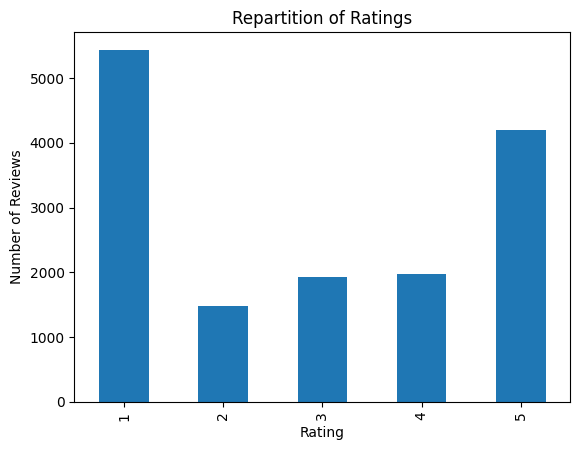

In [7]:
# Define the desired order of ratings
desired_order = [1, 2, 3, 4, 5]

# Calculate the counts of each rating
rating_counts = rws['rating'].value_counts()

# Reindex the rating_counts Series with the desired order
rating_counts = rating_counts.reindex(desired_order)

# Plot the repartition of ratings with the updated x-axis order
rating_counts.plot(kind='bar')

# Set the labels and title
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Repartition of Ratings')

# Show the plot
plt.show()


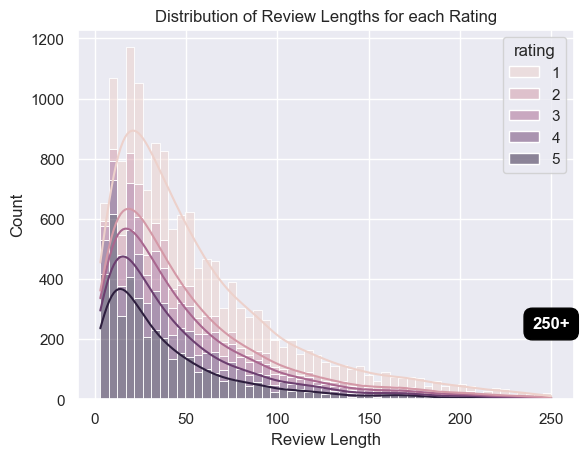

In [8]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set the style of the plot
sns.set(style="darkgrid")

# Calculate the length of reviews
rws['review_length'] = rws['review'].apply(len)

# Filter the review lengths greater than 250
filtered_rws = rws[rws['review_length'] <= 250]

# Plot the distribution of review lengths for each rating
sns.histplot(data=filtered_rws, x="review_length", hue="rating", multiple="stack", kde=True)

# Set the title and labels
plt.title("Distribution of Review Lengths for each Rating")
plt.xlabel("Review Length")
plt.ylabel("Count")

# Add a label for review lengths greater than 250
plt.text(250, 250, '250+', ha='center', va='center', color='white', fontweight='bold', fontsize=12,
         bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.5'))

# Show the plot
plt.show()

In [9]:
# Define a function to preprocess the reviews
longest_review = rws.loc[rws['review_length'].idxmax(), 'review']

print(longest_review)

When the delivery man arrived at my house, he called me to let me know that he had sent the food upstairs with my guard. I asked him to kindly wait downstairs so that I can send him the money to which he replied said the food has been paid for. I was quite taken aback and said that's not possible because I had opted for COD payment, and he just said "achcha ami dekhtesi" and then he just hung up on my face " I mean? Excuse me? I obviously lost my temper, called him back and asked him what sort of nonsense is this and why he kept the phone on my face. He was dumbfounded and did not say a word. I asked him to wait downstairs while I send the guard with the payment. Once your delivery-man had received the payment, he had the audacity to call me back and ask why I said what I said. To recall the conversation, when he hung up on my face my exact words when I called him back were "apni amar mukher upor keno phone rakhlen? Faizlami peyechen apni? Ami toh bolchi cash eh payment hobe, apni nich

In [10]:
rws.drop('review_length', axis=1, inplace=True)

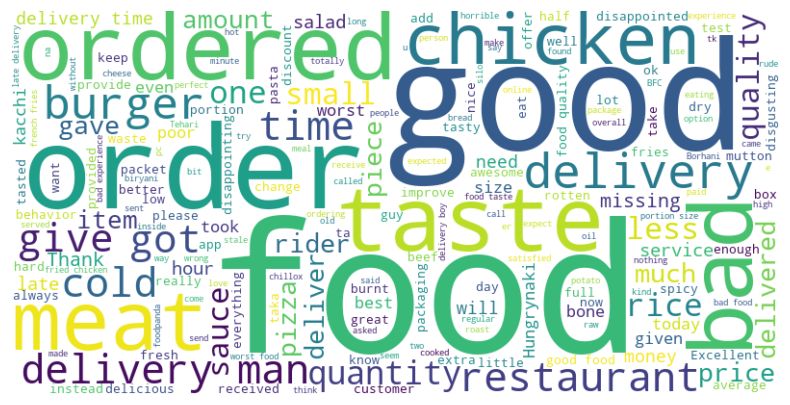

In [11]:
# Concatenate all the reviews into a single string
all_reviews = ' '.join(rws['review'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Plot the wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Text Preprocessing and Data Categorization

### Data Categorization

I will create two categories for my reviews: Positive reviews, which are those with a rating strictly greater than 3, and Negative reviews, which include reviews with a rating strictly less than 3.

In [12]:
# Define a function that categorizes the rating
def categorize_rating(rating):
    if rating > 3:
        return 1
    elif rating < 3:
        return 0
    else:
        return 'Neutral'  # This handles ratings exactly equal to 3

# Apply the function to the 'rating' column
rws['rating'] = rws['rating'].apply(categorize_rating)

# Remove rows where the review_category is 'Neutral'
rws = rws[rws['rating'] != 'Neutral']

# Display the DataFrame to verify that 'Neutral' reviews have been removed
print(rws.head())

                                              review rating
0  To tell you the truth, they sell fried chicken...      0
2  The restaurant provided leas items which I ord...      0
3  already send you a picture about my meal. tota...      0
4                                Excellent as before      1
5  They forgot to include the beverages that were...      0


### Vizualization of the Categorization

Let's take a look at our newly categorized data to gain a clearer insight into how our future models will perform.

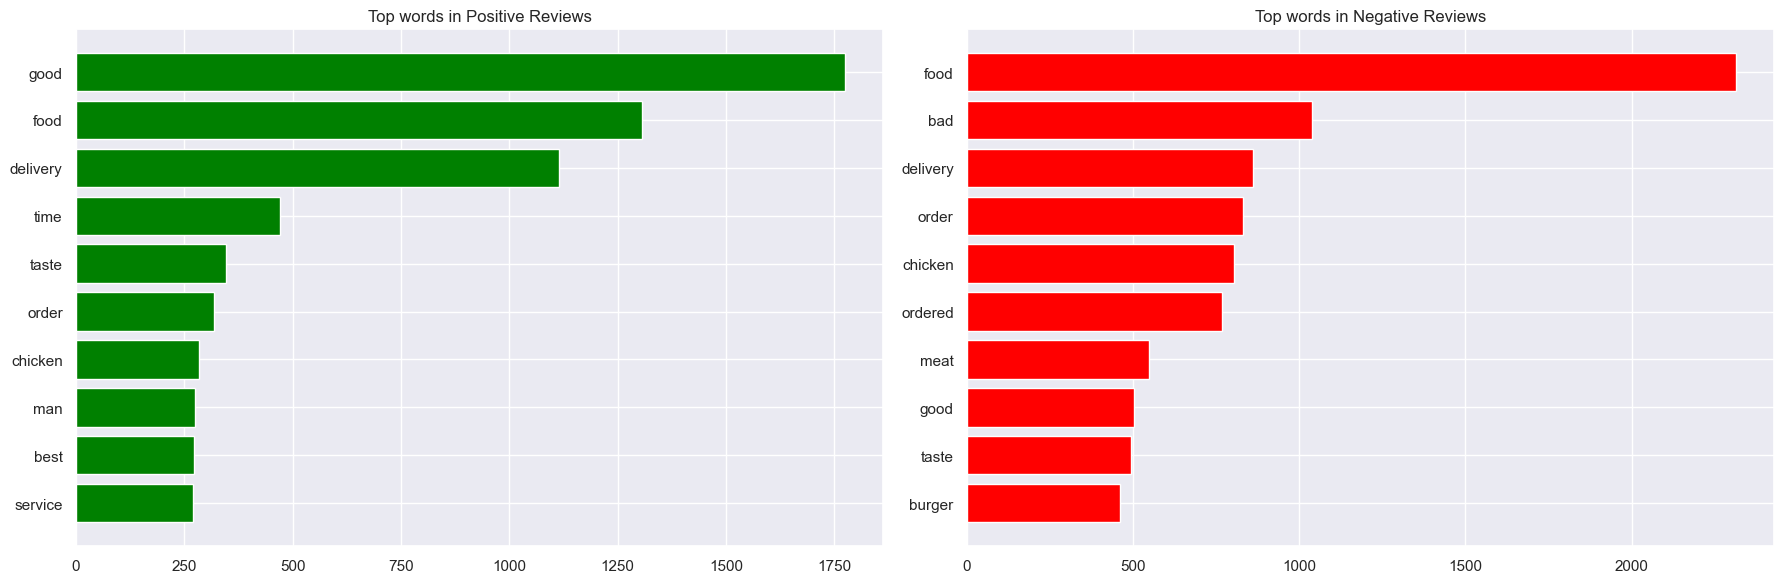

In [13]:
# Tokenize the reviews, remove stopwords, and count the word frequencies for positive and negative reviews separately.

# Function to clean and tokenize text
def clean_tokenize(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return tokens

# Separate positive and negative reviews
positive_reviews = rws[rws['rating'] == 1]['review']
negative_reviews = rws[rws['rating'] == 0]['review']

# Apply the cleaning and tokenization function
positive_tokens = positive_reviews.apply(clean_tokenize).sum()
negative_tokens = negative_reviews.apply(clean_tokenize).sum()

# Count the frequencies of words
positive_freq = Counter(positive_tokens)
negative_freq = Counter(negative_tokens)

# Get the 10 most common words in positive and negative reviews
most_common_positive = positive_freq.most_common(10)
most_common_negative = negative_freq.most_common(10)

# Separate the words and their counts for the plot
positive_words, positive_counts = zip(*most_common_positive)
negative_words, negative_counts = zip(*most_common_negative)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot for positive reviews
ax[0].barh(positive_words, positive_counts, color='green')
ax[0].set_title('Top words in Positive Reviews')
ax[0].invert_yaxis()  # Labels read top-to-bottom

# Plot for negative reviews
ax[1].barh(negative_words, negative_counts, color='red')
ax[1].set_title('Top words in Negative Reviews')
ax[1].invert_yaxis()  # Labels read top-to-bottom

# Display the plot
plt.tight_layout()
plt.show()


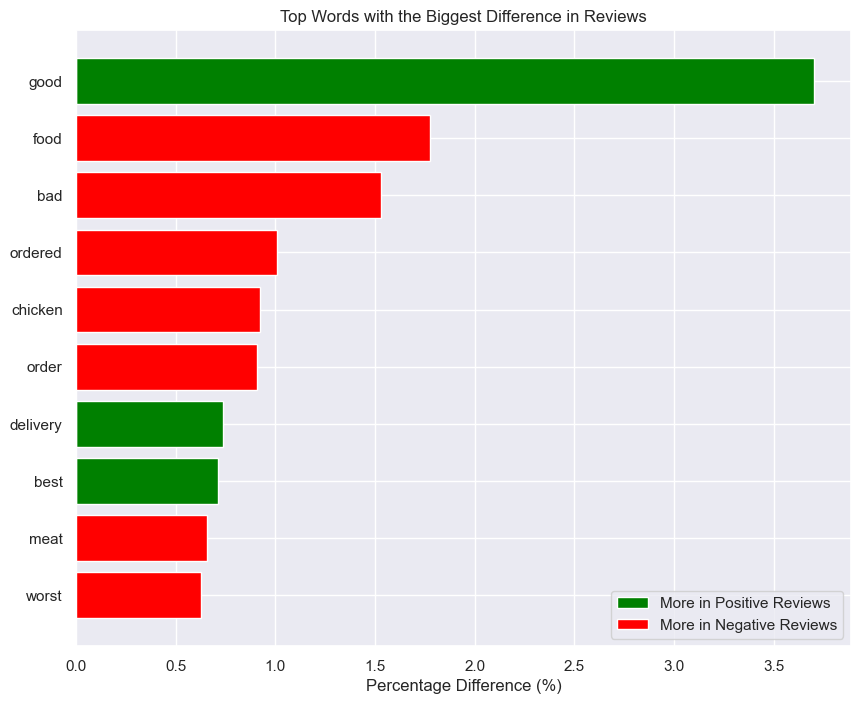

In [14]:
# Calculate the frequency difference for each word
frequency_diff = {word: positive_freq[word] - negative_freq[word] for word in set(positive_freq) | set(negative_freq)}

# Calculate the percentage difference for each word
total_pos_reviews = sum(positive_freq.values())
total_neg_reviews = sum(negative_freq.values())
percentage_diff = {word: (count / total_pos_reviews * 100 if count > 0 else count / total_neg_reviews * 100)
                   for word, count in frequency_diff.items()}

# Sort the words by the biggest absolute percentage difference
sorted_words = sorted(percentage_diff.items(), key=lambda x: abs(x[1]), reverse=True)

# Select the top words with the biggest difference
top_words = sorted_words[:10]  # Adjust the number as needed

# Split words and their percentage difference
words, differences = zip(*top_words)

# Split into positive and negative differences
pos_diffs = [percentage_diff[word] if percentage_diff[word] > 0 else 0 for word in words]
neg_diffs = [-percentage_diff[word] if percentage_diff[word] < 0 else 0 for word in words]

# Plotting
plt.figure(figsize=(10, 8))
y_pos = range(len(words))
plt.barh(y_pos, pos_diffs, color='green', label='More in Positive Reviews')
plt.barh(y_pos, neg_diffs, color='red', label='More in Negative Reviews')
plt.yticks(y_pos, words)
plt.xlabel('Percentage Difference (%)')
plt.title('Top Words with the Biggest Difference in Reviews')
plt.legend()
plt.gca().invert_yaxis()  # Highest percentages on top
plt.show()


### Text Preprocessing and Spliting

I will do text preprocessing in two distinct ways: 

**Large Cleaning Process :** This includes negation handling, emoji removal, lemmatization etc...

**Small Cleaning Process :** This maintaining more of the text's raw form.

*It will be beneficial to evaluate both versions with various models later on.*

Then I will also split the data into training and testing sets.

In [15]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def handle_negation(text):
    if text is None:
        return text
    # Pattern to detect negations followed by an alphanumeric word
    negation_pattern = re.compile(r'\b(not|no|never|none|nothing|nowhere|neither|nobody|cannot)\b[\s]*(\w+)')
    text = negation_pattern.sub(lambda x: f'{x.group(1)}_{x.group(2)}', text)
    return text

def full_clean_text(text):
    # If text is None or empty, return it as it is
    if text is None or text == '':
        return text
    # Handle negation
    text = handle_negation(text)
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # POS tagging
    nltk_pos_tagged = nltk.pos_tag(words)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_pos_tagged)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in wordnet_tagged]
    return ' '.join(lemmatized_words)

def raw_clean_text(text):
    # If text is None or empty, return it as it is
    if text is None or text == '':
        return text
    # Tokenize text
    words = word_tokenize(text)
    return ' '.join(words)

In [16]:
# Balance the dataset
# Separate the dataset into positives and negatives
positive_rws = rws[rws['rating'] == 1]
negative_rws = rws[rws['rating'] == 0]

# Downsample the majority class (positive reviews) to match the minority class (negative reviews)
min_count = min(len(positive_rws), len(negative_rws))
balanced_positive = positive_rws.sample(n=min_count, random_state=42)
balanced_negative = negative_rws.sample(n=min_count, random_state=42)

# Combine back to a single balanced dataframe
balanced_rws = pd.concat([balanced_positive, balanced_negative])

# Now perform a stratified split on the balanced dataset
train_rws, test_rws = train_test_split(balanced_rws, test_size=0.2, stratify=balanced_rws['rating'], random_state=42)

# Apply the thorough cleaning to the training and test sets
# Create new DataFrame for cleaned versions including ratings
cleaned_train = pd.DataFrame({
    'review': train_rws['review'].apply(full_clean_text),
    'rating': train_rws['rating']
})
cleaned_test = pd.DataFrame({
    'review': test_rws['review'].apply(full_clean_text),
    'rating': test_rws['rating']
})

# Apply the minimal cleaning to the training and test sets
# Create new DataFrame for raw versions including ratings
raw_train = pd.DataFrame({
    'review': train_rws['review'].apply(raw_clean_text),
    'rating': train_rws['rating']
})
raw_test = pd.DataFrame({
    'review': test_rws['review'].apply(raw_clean_text),
    'rating': test_rws['rating']
})

In [17]:
# Print the first two reviews from the cleaned training set
print("First two reviews from the Cleaned Training Set:")
print(cleaned_train['review'].iloc[0])
print(cleaned_train['review'].iloc[1])
print("\n")

# Print the first two reviews from the cleaned test set
print("First two reviews from the Cleaned Test Set:")
print(cleaned_test['review'].iloc[0])
print(cleaned_test['review'].iloc[1])
print("\n")

# Assuming the same indices can be used for the raw sets, since the split was stratified based on the rating
print("First two reviews from the Raw Training Set:")
print(raw_train['review'].iloc[0])
print(raw_train['review'].iloc[1])
print("\n")

print("First two reviews from the Raw Test Set:")
print(raw_test['review'].iloc[0])
print(raw_test['review'].iloc[1])

First two reviews from the Cleaned Training Set:
bhuna khichuri plenty meatbeef ittaste also good
delivery time


First two reviews from the Cleaned Test Set:
bad food cold soggy bag rip entire soda go waste no_cheese cheeseburger
please continue consistency pizza excellent taste really fresh also whole family could enjoy definitely order


First two reviews from the Raw Training Set:
Bhuna khichuri had plenty of meat ( Beef ) in it.Taste was also good .
delivery time


First two reviews from the Raw Test Set:
It was very bad . The food was cold and soggy . The bag ripped and my entire soda went to waste . And there was no cheese in my cheeseburger
Please continue this consistency ! The pizza is excellent ! It tasted really fresh ! Also my whole family could enjoy it . Definitely ordering again .


In [18]:
# Count the occurrences of each class in the 'rating' column for both training and test sets
count_train = Counter(cleaned_train['rating'])
count_test = Counter(cleaned_test['rating'])
count_raw_train = Counter(raw_train['rating'])
count_raw_test = Counter(raw_test['rating'])

print("Counts for Cleaned Training Set:", count_train)
print("Counts for Cleaned Test Set:", count_test)
print("Counts for Raw Training Set:", count_raw_train)
print("Counts for Raw Test Set:", count_raw_test)


Counts for Cleaned Training Set: Counter({1: 4942, 0: 4942})
Counts for Cleaned Test Set: Counter({0: 1236, 1: 1236})
Counts for Raw Training Set: Counter({1: 4942, 0: 4942})
Counts for Raw Test Set: Counter({0: 1236, 1: 1236})


## Modelling

### Naive Bayes

First, I will be evaluating a Multinomial Naive Bayes model as my baseline

#### Naive Bayes with cleaned data (TF-IDF)

In [19]:
# Convert ratings to numeric codes if they are categorical
cleaned_train['rating'] = cleaned_train['rating'].astype('category').cat.codes
cleaned_test['rating'] = cleaned_test['rating'].astype('category').cat.codes

cX_train = cleaned_train['review']
cy_train = cleaned_train['rating']
cX_test = cleaned_test['review']
cy_test = cleaned_test['rating']

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
cX_train_tfidf = tfidf_vectorizer.fit_transform(cX_train)
cX_test_tfidf = tfidf_vectorizer.transform(cX_test)

# Training a Multinomial Naive Bayes model
model_0cTI = MultinomialNB()
model_0cTI.fit(cX_train_tfidf, cy_train)

# Predicting the ratings
start_time = timeit.default_timer()
cy_pred = model_0cTI.predict(cX_test_tfidf)
end_time = timeit.default_timer()

# Calculate time per instance
m0cTI_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate other metrics
m0cTI_accuracy = accuracy_score(cy_test, cy_pred)
m0cTI_precision = precision_score(cy_test, cy_pred, average='weighted')
m0cTI_recall = recall_score(cy_test, cy_pred, average='weighted')
m0cTI_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m0cTI_accuracy:.2%}", f"{m0cTI_precision:.3f}", f"{m0cTI_recall:.3f}", f"{m0cTI_f1:.3f}", f"{m0cTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))


Model Performance          Results
         accuracy           78.80%
        precision            0.793
           recall            0.788
         f1_score            0.787
    time/instance 0.000000 seconds


#### Naive Bayes with raw data (TF-IDF)

In [20]:
# Convert ratings to numeric codes if they are categorical
raw_train['rating'] = raw_train['rating'].astype('category').cat.codes
raw_test['rating'] = raw_test['rating'].astype('category').cat.codes

rX_train = raw_train['review']
ry_train = raw_train['rating']
rX_test = raw_test['review']
ry_test = raw_test['rating']

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
rX_train_tfidf = tfidf_vectorizer.fit_transform(rX_train)
rX_test_tfidf = tfidf_vectorizer.transform(rX_test)

# Training a Multinomial Naive Bayes model
model_0rTI = MultinomialNB()
model_0rTI.fit(rX_train_tfidf, ry_train)

# Predicting the ratings
start_time = timeit.default_timer()
ry_pred = model_0rTI.predict(rX_test_tfidf)
end_time = timeit.default_timer()

# Calculate time per instance
m0rTI_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate other metrics
m0rTI_accuracy = accuracy_score(ry_test, ry_pred)
m0rTI_precision = precision_score(ry_test, ry_pred, average='weighted')
m0rTI_recall = recall_score(ry_test, ry_pred, average='weighted')
m0rTI_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m0rTI_accuracy:.2%}", f"{m0rTI_precision:.3f}", f"{m0rTI_recall:.3f}", f"{m0rTI_f1:.3f}", f"{m0rTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

Model Performance          Results
         accuracy           78.92%
        precision            0.795
           recall            0.789
         f1_score            0.788
    time/instance 0.000000 seconds


#### Storing Results

In [21]:
# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Time per Instance'])

def store_results(model_name, accuracy, precision, recall, f1_score, time_per_instance):
    # Append the new results to the DataFrame
    results_df.loc[len(results_df)] = {
        'Model': model_name,
        'Accuracy': f"{accuracy:.2%}",
        'Precision': f"{precision:.3f}",
        'Recall': f"{recall:.3f}",
        'F1 Score': f"{f1_score:.3f}",
        'Time per Instance': f"{time_per_instance:.6f} seconds"
    }

# Store the results for the cleaned text model with TF-IDF
store_results('Model_0cTI', m0cTI_accuracy, m0cTI_precision, m0cTI_recall, m0cTI_f1, m0cTI_time_per_instance)

# Store the results for the raw text model with TF-IDF
store_results('Model_0rTI', m0rTI_accuracy, m0rTI_precision, m0rTI_recall, m0rTI_f1, m0rTI_time_per_instance)

# View the consolidated results
print(results_df)


        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds


### FNN

My initial model is a Feedforward Neural Network (FNN) with 2 different vectorization (TF-IDF and Word2Vec)

#### FNN with cleaned data (TF-IDF)

In [22]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(cX_train_tfidf.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [23]:
param_grid = {
    'neurons': [128, 256],  # Starting neurons for the first layer
    'num_layers': [1, 2],  # Varying numbers of layers
    'learning_rate': [0.001, 0.0001],
    'regularization': [0, 0.001]  # Adding regularization to the grid search
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(cX_train_tfidf, cy_train, callbacks=[early_stopping])

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6861 - loss: 0.6477
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8261 - loss: 0.4396
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8507 - loss: 0.3589
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8775 - loss: 0.3180
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8910 - loss: 0.2854
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8997 - loss: 0.2621
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9056 - loss: 0.2548
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9149 - loss: 0.2286
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9194 - loss: 0.2143
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9165 - loss: 0.2079
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9204 - loss: 0.2053
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7223 - loss: 0.6466
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8331 - loss: 0.4277
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8689 - loss: 0.3485
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8763 - loss: 0.3160
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9000 - loss: 0.2705
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9047 - loss: 0.2511
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9004 - loss: 0.2476
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9151 - loss: 0.2215
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9143 - loss: 0.2161
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9258 - loss: 0.2011
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9219 - loss: 0.1972
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7104 - loss: 0.6442
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8378 - loss: 0.4207
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8695 - loss: 0.3363
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8810 - loss: 0.3142
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8951 - loss: 0.2757
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9095 - loss: 0.2544
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9084 - loss: 0.2323
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9170 - loss: 0.2198
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9222 - loss: 0.2100
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9224 - loss: 0.2025
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9266 - loss: 0.1894
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7115 - loss: 0.7113
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8023 - loss: 0.5431
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8244 - loss: 0.5159
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8241 - loss: 0.5113
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8314 - loss: 0.4991
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8346 - loss: 0.4869
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8473 - loss: 0.4793
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8422 - loss: 0.4765
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8548 - loss: 0.4686
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8505 - loss: 0.4694
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8600 - loss: 0.4639
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7096 - loss: 0.7123
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8083 - loss: 0.5446
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8201 - loss: 0.5140
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8291 - loss: 0.4959
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8344 - loss: 0.4978
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8371 - loss: 0.4838
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8400 - loss: 0.4810
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8517 - loss: 0.4716
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8508 - loss: 0.4735
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8497 - loss: 0.4727
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8568 - loss: 0.4597
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7074 - loss: 0.7110
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8070 - loss: 0.5307
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8253 - loss: 0.5080
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8344 - loss: 0.4914
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8413 - loss: 0.4829
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8501 - loss: 0.4757
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8541 - loss: 0.4691
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8441 - loss: 0.4715
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8550 - loss: 0.4624
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8591 - loss: 0.4554
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8606 - loss: 0.4521
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6771 - loss: 0.6198
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8454 - loss: 0.3730
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8765 - loss: 0.3131
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8861 - loss: 0.2785
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9002 - loss: 0.2533
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9050 - loss: 0.2346
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9087 - loss: 0.2188
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9230 - loss: 0.2023
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9167 - loss: 0.1936
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9234 - loss: 0.1859
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9228 - loss: 0.1897
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6961 - loss: 0.6198
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8467 - loss: 0.3735
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8845 - loss: 0.2933
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8948 - loss: 0.2686
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9088 - loss: 0.2266
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9072 - loss: 0.2272
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9148 - loss: 0.2118
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9192 - loss: 0.1993
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9272 - loss: 0.1916
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9279 - loss: 0.1844
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9203 - loss: 0.1921
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6711 - loss: 0.6174
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8504 - loss: 0.3681
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8902 - loss: 0.2926
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9005 - loss: 0.2598
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9149 - loss: 0.2273
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9170 - loss: 0.2152
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9194 - loss: 0.2057
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9163 - loss: 0.2067
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9255 - loss: 0.1897
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9189 - loss: 0.1952
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9271 - loss: 0.1828
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6790 - loss: 0.7537
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8171 - loss: 0.5237
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8432 - loss: 0.5028
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8486 - loss: 0.4922
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8477 - loss: 0.4870
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8539 - loss: 0.4756
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8684 - loss: 0.4651
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8672 - loss: 0.4563
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8621 - loss: 0.4650
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8711 - loss: 0.4529
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8679 - loss: 0.4521
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6708 - loss: 0.7523
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8129 - loss: 0.5292
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8483 - loss: 0.4917
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8558 - loss: 0.4829
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8503 - loss: 0.4789
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8615 - loss: 0.4672
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8694 - loss: 0.4540
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8698 - loss: 0.4486
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8708 - loss: 0.4475
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8816 - loss: 0.4344
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8856 - loss: 0.4328
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6720 - loss: 0.7505
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8209 - loss: 0.5119
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8505 - loss: 0.4917
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8539 - loss: 0.4780
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8592 - loss: 0.4762
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8694 - loss: 0.4575
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8795 - loss: 0.4382
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8771 - loss: 0.4435
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8864 - loss: 0.4231
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8866 - loss: 0.4320
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8897 - loss: 0.4192
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6903 - loss: 0.6325
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8305 - loss: 0.4054
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8697 - loss: 0.3382
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8843 - loss: 0.2948
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8997 - loss: 0.2605
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9060 - loss: 0.2411
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9143 - loss: 0.2243
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9075 - loss: 0.2222
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9149 - loss: 0.2152
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9259 - loss: 0.1931
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9213 - loss: 0.1964
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7061 - loss: 0.6316
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8391 - loss: 0.4009
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8691 - loss: 0.3308
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8966 - loss: 0.2818
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9057 - loss: 0.2476
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9108 - loss: 0.2326
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9127 - loss: 0.2214
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9181 - loss: 0.2155
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9193 - loss: 0.2056
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9156 - loss: 0.2079
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9227 - loss: 0.1912
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7161 - loss: 0.6273
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8436 - loss: 0.3893
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8816 - loss: 0.3117
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8926 - loss: 0.2762
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9044 - loss: 0.2471
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9187 - loss: 0.2250
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9165 - loss: 0.2243
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9256 - loss: 0.1960
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9179 - loss: 0.2093
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9295 - loss: 0.1897
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9191 - loss: 0.1925
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7010 - loss: 0.7523
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8090 - loss: 0.5411
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8154 - loss: 0.5231
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8170 - loss: 0.5230
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8304 - loss: 0.5161
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8371 - loss: 0.5023
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8354 - loss: 0.5014
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8435 - loss: 0.5001
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8444 - loss: 0.5006
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8447 - loss: 0.4932
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8404 - loss: 0.4985
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7062 - loss: 0.7514
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8035 - loss: 0.5367
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8244 - loss: 0.5211
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8306 - loss: 0.5134
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8317 - loss: 0.5015
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8319 - loss: 0.5034
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8369 - loss: 0.4967
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8319 - loss: 0.5006
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8488 - loss: 0.4821
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8434 - loss: 0.4924
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8497 - loss: 0.4824
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7088 - loss: 0.7488
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8023 - loss: 0.5370
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8225 - loss: 0.5159
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8368 - loss: 0.4953
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8364 - loss: 0.4988
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8464 - loss: 0.4878
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8445 - loss: 0.4829
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8478 - loss: 0.4910
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8557 - loss: 0.4735
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8475 - loss: 0.4804
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8433 - loss: 0.4843
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7027 - loss: 0.5962
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8535 - loss: 0.3591
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8804 - loss: 0.2965
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8995 - loss: 0.2592
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9028 - loss: 0.2420
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9096 - loss: 0.2296
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9142 - loss: 0.2141
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9105 - loss: 0.2130
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9190 - loss: 0.1966
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9282 - loss: 0.1871
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9232 - loss: 0.1879
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7049 - loss: 0.5975
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8476 - loss: 0.3611
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8902 - loss: 0.2805
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9023 - loss: 0.2487
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9055 - loss: 0.2260
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9057 - loss: 0.2223
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9133 - loss: 0.2106
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9166 - loss: 0.1982
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9158 - loss: 0.1976
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9148 - loss: 0.1977
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9245 - loss: 0.1780
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6971 - loss: 0.5948
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8653 - loss: 0.3358
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8824 - loss: 0.2909
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8999 - loss: 0.2522
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9133 - loss: 0.2252
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9158 - loss: 0.2063
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9170 - loss: 0.2084
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9193 - loss: 0.1981
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9263 - loss: 0.1775
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9299 - loss: 0.1813
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9223 - loss: 0.1808
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6861 - loss: 0.8238
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8148 - loss: 0.5388
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8230 - loss: 0.5191
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8387 - loss: 0.5123
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8459 - loss: 0.5012
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8490 - loss: 0.4944
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8592 - loss: 0.4834
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8627 - loss: 0.4643
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8688 - loss: 0.4553
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8813 - loss: 0.4300
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8846 - loss: 0.4288
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6787 - loss: 0.8214
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8133 - loss: 0.5316
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8310 - loss: 0.5217
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8455 - loss: 0.5062
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8569 - loss: 0.4872
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8675 - loss: 0.4751
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8627 - loss: 0.4652
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8695 - loss: 0.4478
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8697 - loss: 0.4494
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8782 - loss: 0.4407
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8868 - loss: 0.4331
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7027 - loss: 0.8182
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8200 - loss: 0.5230
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8311 - loss: 0.5077
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8435 - loss: 0.4894
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8619 - loss: 0.4712
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8642 - loss: 0.4701
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8660 - loss: 0.4616
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8729 - loss: 0.4462
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8835 - loss: 0.4359
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8915 - loss: 0.4274
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8846 - loss: 0.4258
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6292 - loss: 0.6897
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7859 - loss: 0.6719
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8049 - loss: 0.6485
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8120 - loss: 0.6160
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8178 - loss: 0.5847
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8228 - loss: 0.5516
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8210 - loss: 0.5183
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8369 - loss: 0.4903
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8370 - loss: 0.4676
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8361 - loss: 0.4558
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8467 - loss: 0.4303
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5989 - loss: 0.6901
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7916 - loss: 0.6723
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8149 - loss: 0.6480
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8247 - loss: 0.6147
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8251 - loss: 0.5813
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8336 - loss: 0.5474
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8316 - loss: 0.5194
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8442 - loss: 0.4874
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8454 - loss: 0.4651
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8555 - loss: 0.4387
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8668 - loss: 0.4176
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6018 - loss: 0.6905
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7974 - loss: 0.6730
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8198 - loss: 0.6475
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8267 - loss: 0.6158
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8362 - loss: 0.5765
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8342 - loss: 0.5439
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8406 - loss: 0.5113
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8409 - loss: 0.4884
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8460 - loss: 0.4616
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8475 - loss: 0.4409
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8599 - loss: 0.4202
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6237 - loss: 0.8640
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7855 - loss: 0.7101
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7998 - loss: 0.6697
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8028 - loss: 0.6438
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8090 - loss: 0.6183
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8063 - loss: 0.6019
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8069 - loss: 0.5807
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8077 - loss: 0.5672
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8182 - loss: 0.5489
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8127 - loss: 0.5436
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8157 - loss: 0.5326
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6101 - loss: 0.8641
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7889 - loss: 0.7102
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7975 - loss: 0.6687
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8174 - loss: 0.6400
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8071 - loss: 0.6168
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8007 - loss: 0.5955
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8221 - loss: 0.5703
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8174 - loss: 0.5574
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8212 - loss: 0.5471
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8270 - loss: 0.5316
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8278 - loss: 0.5234
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6166 - loss: 0.8638
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7872 - loss: 0.7089
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8062 - loss: 0.6687
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8142 - loss: 0.6405
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8104 - loss: 0.6176
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8191 - loss: 0.5920
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8258 - loss: 0.5716
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8218 - loss: 0.5576
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8209 - loss: 0.5481
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8264 - loss: 0.5293
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8253 - loss: 0.5255
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6067 - loss: 0.6907
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7805 - loss: 0.6699
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8022 - loss: 0.5995
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8238 - loss: 0.4998
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8296 - loss: 0.4309
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8423 - loss: 0.4021
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8555 - loss: 0.3712
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8613 - loss: 0.3471
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8659 - loss: 0.3355
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8740 - loss: 0.3155
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8805 - loss: 0.3076
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6115 - loss: 0.6907
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7938 - loss: 0.6702
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8251 - loss: 0.5994
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8263 - loss: 0.5013
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8361 - loss: 0.4383
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8581 - loss: 0.3875
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8640 - loss: 0.3585
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8643 - loss: 0.3514
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8708 - loss: 0.3311
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8827 - loss: 0.3061
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8953 - loss: 0.2957
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6116 - loss: 0.6911
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7956 - loss: 0.6709
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8181 - loss: 0.5986
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8287 - loss: 0.4964
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8450 - loss: 0.4244
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8557 - loss: 0.3809
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8626 - loss: 0.3597
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8690 - loss: 0.3402
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8829 - loss: 0.3114
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8858 - loss: 0.3055
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8885 - loss: 0.2962
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6272 - loss: 0.9428
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7662 - loss: 0.7692
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7945 - loss: 0.7083
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8079 - loss: 0.6411
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7990 - loss: 0.5851
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8127 - loss: 0.5471
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8314 - loss: 0.5206
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8292 - loss: 0.5164
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8428 - loss: 0.4938
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8462 - loss: 0.4943
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8445 - loss: 0.4821
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5661 - loss: 0.9433
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7806 - loss: 0.7693
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7888 - loss: 0.7180
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8030 - loss: 0.6576
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8161 - loss: 0.5934
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8227 - loss: 0.5464
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8338 - loss: 0.5260
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8345 - loss: 0.5084
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8435 - loss: 0.4965
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8480 - loss: 0.4968
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8608 - loss: 0.4755
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5751 - loss: 0.9422
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7850 - loss: 0.7683
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8029 - loss: 0.7073
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8042 - loss: 0.6380
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8239 - loss: 0.5716
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8276 - loss: 0.5329
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8392 - loss: 0.5165
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8346 - loss: 0.5016
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8474 - loss: 0.4843
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8538 - loss: 0.4756
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8539 - loss: 0.4706
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6493 - loss: 0.6881
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8086 - loss: 0.6612
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8129 - loss: 0.6225
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8186 - loss: 0.5782
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8366 - loss: 0.5247
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8257 - loss: 0.4965
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8377 - loss: 0.4574
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8493 - loss: 0.4278
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8479 - loss: 0.4147
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8459 - loss: 0.4046
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8595 - loss: 0.3790
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6556 - loss: 0.6882
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8065 - loss: 0.6611
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8215 - loss: 0.6225
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8277 - loss: 0.5743
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8363 - loss: 0.5291
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8409 - loss: 0.4927
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8505 - loss: 0.4527
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8551 - loss: 0.4350
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8605 - loss: 0.4100
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8639 - loss: 0.3939
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8654 - loss: 0.3843
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6295 - loss: 0.6884
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7917 - loss: 0.6611
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8038 - loss: 0.6214
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8181 - loss: 0.5753
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8397 - loss: 0.5226
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8357 - loss: 0.4845
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8502 - loss: 0.4534
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8474 - loss: 0.4274
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8613 - loss: 0.4010
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8611 - loss: 0.3862
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8677 - loss: 0.3701
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6509 - loss: 1.0261
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8056 - loss: 0.7242
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8005 - loss: 0.6585
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8034 - loss: 0.6205
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8085 - loss: 0.5892
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8136 - loss: 0.5659
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8173 - loss: 0.5441
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8216 - loss: 0.5330
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8129 - loss: 0.5307
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8217 - loss: 0.5166
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8260 - loss: 0.5047
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6446 - loss: 1.0268
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7898 - loss: 0.7250
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8070 - loss: 0.6560
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8003 - loss: 0.6216
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8084 - loss: 0.5871
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8112 - loss: 0.5692
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8137 - loss: 0.5490
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8192 - loss: 0.5378
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8238 - loss: 0.5214
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8256 - loss: 0.5184
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8330 - loss: 0.4995
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6521 - loss: 1.0251
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7901 - loss: 0.7231
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8067 - loss: 0.6550
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8173 - loss: 0.6152
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8190 - loss: 0.5848
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8187 - loss: 0.5621
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8187 - loss: 0.5439
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8224 - loss: 0.5260
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8240 - loss: 0.5178
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8295 - loss: 0.5063
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8256 - loss: 0.5053
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6199 - loss: 0.6896
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7861 - loss: 0.6398
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8192 - loss: 0.4974
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8422 - loss: 0.4127
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8535 - loss: 0.3699
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8674 - loss: 0.3415
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8708 - loss: 0.3313
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8815 - loss: 0.3037
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8903 - loss: 0.2905
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8946 - loss: 0.2786
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8990 - loss: 0.2670
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6199 - loss: 0.6901
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8026 - loss: 0.6449
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8185 - loss: 0.5096
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8421 - loss: 0.4177
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8600 - loss: 0.3644
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8770 - loss: 0.3285
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8760 - loss: 0.3186
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8860 - loss: 0.2944
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8924 - loss: 0.2724
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9022 - loss: 0.2573
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8988 - loss: 0.2626
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6255 - loss: 0.6893
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7920 - loss: 0.6369
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8260 - loss: 0.4894
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8393 - loss: 0.4041
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8680 - loss: 0.3510
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8824 - loss: 0.3170
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8829 - loss: 0.3052
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8893 - loss: 0.2897
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8919 - loss: 0.2715
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9002 - loss: 0.2596
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9059 - loss: 0.2493
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5950 - loss: 1.1797
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7797 - loss: 0.8200
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7962 - loss: 0.6878
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8102 - loss: 0.5941
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8303 - loss: 0.5277
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8290 - loss: 0.5188
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8392 - loss: 0.5028
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8484 - loss: 0.4773
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8495 - loss: 0.4792
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8565 - loss: 0.4594
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8675 - loss: 0.4574
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6433 - loss: 1.1793
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7853 - loss: 0.8180
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8067 - loss: 0.6834
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8094 - loss: 0.5931
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8305 - loss: 0.5449
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8356 - loss: 0.5282
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8514 - loss: 0.4986
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8615 - loss: 0.4842
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8602 - loss: 0.4652
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8604 - loss: 0.4737
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8689 - loss: 0.4626
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6265 - loss: 1.1792
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8024 - loss: 0.8167
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8093 - loss: 0.6770
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8241 - loss: 0.5836
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8331 - loss: 0.5306
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8399 - loss: 0.5038
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8466 - loss: 0.4885
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8631 - loss: 0.4735
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8599 - loss: 0.4651
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8575 - loss: 0.4582
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8664 - loss: 0.4518
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6593 - loss: 0.9776
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7955 - loss: 0.6782
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7935 - loss: 0.6193
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8021 - loss: 0.5777
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7982 - loss: 0.5546
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8064 - loss: 0.5360
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8136 - loss: 0.5204
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8179 - loss: 0.5101
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8188 - loss: 0.5074
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8228 - loss: 0.4960
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8247 - loss: 0.4973
Epoch 12/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 

In [24]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.794110 using {'learning_rate': 0.0001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.728146 (0.003260) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.775697 (0.007584) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.734621 (0.006796) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.768009 (0.002653) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.728043 (0.014513) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.774989 (0.008275) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.730776 (0.008012) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.769728 (0.009578) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.788951 (0.007491) with: {'learning_ra

In [25]:
# Extract the best parameters
best_params = grid_result.best_params_

In [26]:
# Create the final model using the best parameters
model_1cTI = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_1cTI.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_122 (Dense)               │ (None, 256)            │     1,714,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,714,433 (6.54 MB)

 Trainable params: 1,714,433 (6.54 MB)

 Non-trainable params: 0 (0.00 B)

None


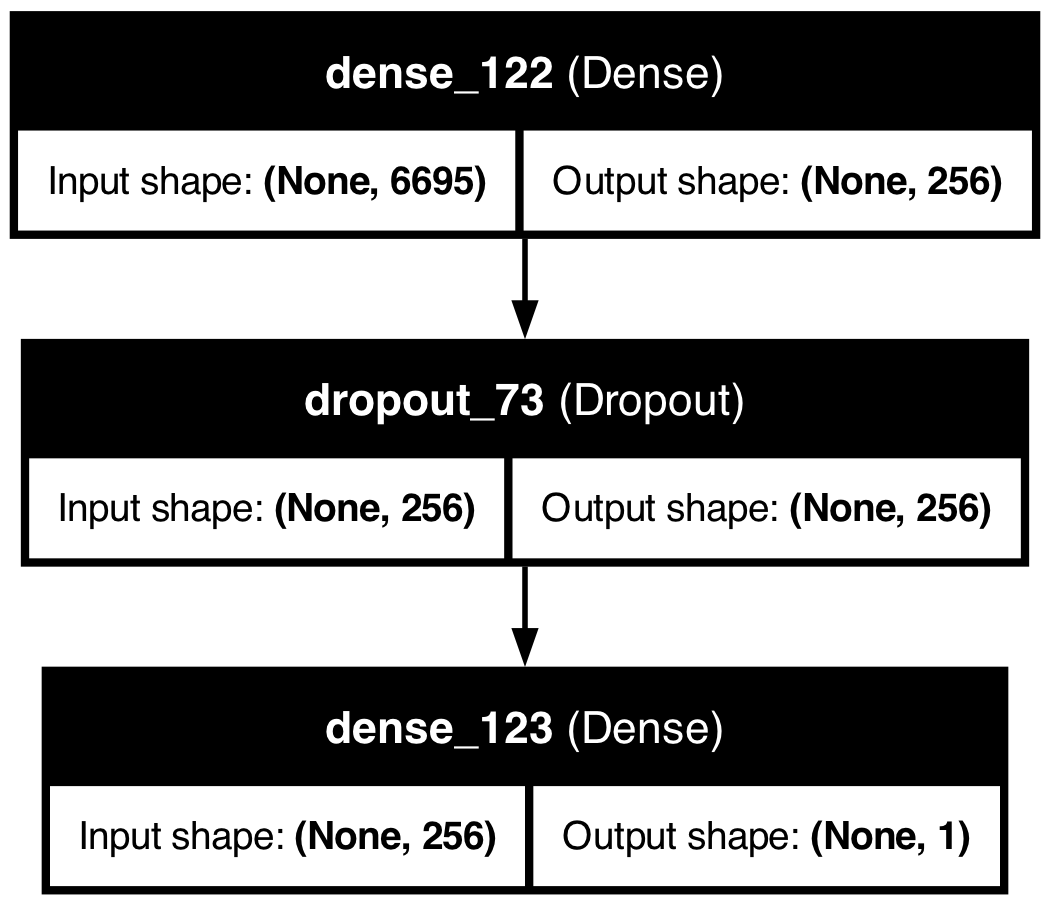

In [27]:
# Generate the plot
plot_model(model_1cTI, show_shapes=True, show_layer_names=True)

In [28]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_1cTI_history = model_1cTI.fit(
    cX_train_tfidf, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/300
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6312 - loss: 1.0058
Epoch 1: val_loss improved from inf to 0.72861, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6319 - loss: 1.0048 - val_accuracy: 0.7673 - val_loss: 0.7286 - learning_rate: 1.0000e-04
Epoch 2/300
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7937 - loss: 0.7019
Epoch 2: val_loss improved from 0.72861 to 0.65685, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7936 - loss: 0.7017 - val_accuracy: 0.7678 - val_loss: 0.6568 - learning_rate: 1.0000e-04
Epoch 3/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8047 - loss: 0.6402
Epoch 3: val_loss improved from 0.65685 to 0.61848, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8047 - loss: 0.6402 - val_accuracy: 0.7699 - val_loss: 0.6185 - learning_rate: 1.0000e-04
Epoch 4/300
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 12m

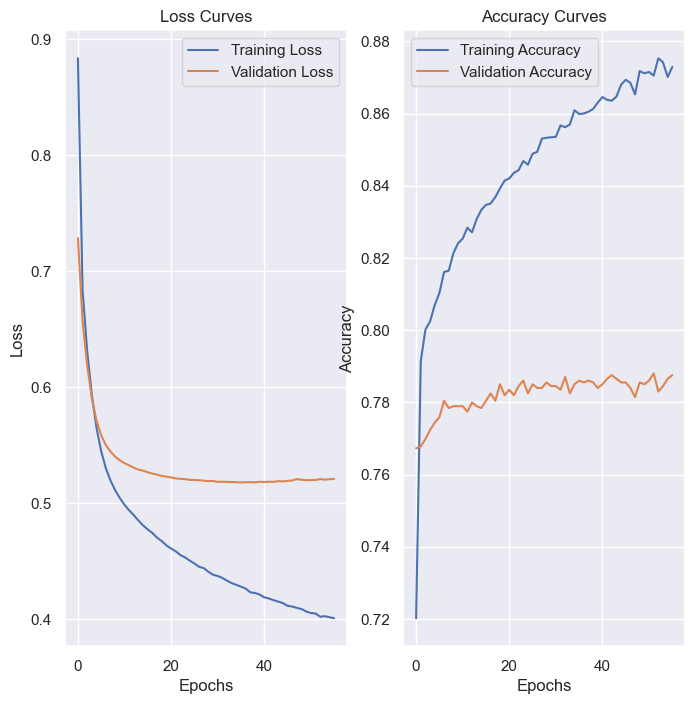

In [29]:
# Create a function to vizuualize the training and validation loss and accuracy
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    Args:
    history: TensorFlow History object.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    
# Use the function with your model's history
plot_loss_curves(model_1cTI_history)

In [30]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_1cTI.predict(cX_test_tfidf)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1cTI_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate accuracy, precision, recall, and f1 score
m1cTI_accuracy = accuracy_score(cy_test, cy_pred)
m1cTI_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1cTI_recall = recall_score(cy_test, cy_pred, average='weighted')
m1cTI_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1cTI_accuracy:.2%}", f"{m1cTI_precision:.3f}", f"{m1cTI_recall:.3f}", f"{m1cTI_f1:.3f}", f"{m1cTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Performance          Results
         accuracy           78.07%
        precision            0.782
           recall            0.781
         f1_score            0.780
    time/instance 0.000191 seconds


In [31]:
store_results('Model_1cTI', m1cTI_accuracy, m1cTI_precision, m1cTI_recall, m1cTI_f1, m1cTI_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.07%     0.782  0.781    0.780  0.000191 seconds


#### FNN with raw data (TF-IDF)

In [32]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(rX_train_tfidf.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [33]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(rX_train_tfidf, ry_train, callbacks=[early_stopping])

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/30


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7171 - loss: 0.6473
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8206 - loss: 0.4359
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8521 - loss: 0.3569
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8730 - loss: 0.3150
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8897 - loss: 0.2827
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9002 - loss: 0.2626
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9033 - loss: 0.2467
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9131 - loss: 0.2317
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9185 - loss: 0.2172
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9241 - loss: 0.2088
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9228 - loss: 0.2168
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6809 - loss: 0.6468
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8276 - loss: 0.4259
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8593 - loss: 0.3525
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8788 - loss: 0.3033
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8974 - loss: 0.2691
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9025 - loss: 0.2606
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9120 - loss: 0.2290
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9175 - loss: 0.2226
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9202 - loss: 0.2124
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9233 - loss: 0.2008
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9198 - loss: 0.2031
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7239 - loss: 0.6447
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8333 - loss: 0.4163
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8626 - loss: 0.3472
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8876 - loss: 0.3002
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8956 - loss: 0.2744
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9113 - loss: 0.2424
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9079 - loss: 0.2356
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9195 - loss: 0.2151
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9155 - loss: 0.2205
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9250 - loss: 0.1967
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9255 - loss: 0.1914
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7084 - loss: 0.7129
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7935 - loss: 0.5426
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8248 - loss: 0.5032
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8215 - loss: 0.4972
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8312 - loss: 0.4891
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8290 - loss: 0.4884
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8438 - loss: 0.4720
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8419 - loss: 0.4668
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8422 - loss: 0.4694
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8454 - loss: 0.4578
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8599 - loss: 0.4503
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6950 - loss: 0.7143
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8008 - loss: 0.5353
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8135 - loss: 0.5202
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8301 - loss: 0.4952
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8329 - loss: 0.4901
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8352 - loss: 0.4879
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8420 - loss: 0.4682
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8490 - loss: 0.4606
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8484 - loss: 0.4654
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8522 - loss: 0.4569
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8592 - loss: 0.4522
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7034 - loss: 0.7114
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7952 - loss: 0.5367
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8208 - loss: 0.5071
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8308 - loss: 0.4910
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8291 - loss: 0.4876
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8442 - loss: 0.4722
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8434 - loss: 0.4632
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8428 - loss: 0.4742
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8488 - loss: 0.4615
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8548 - loss: 0.4506
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8466 - loss: 0.4588
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6461 - loss: 0.6191
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8386 - loss: 0.3704
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8669 - loss: 0.3149
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8966 - loss: 0.2658
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9061 - loss: 0.2456
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9166 - loss: 0.2215
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9165 - loss: 0.2187
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9197 - loss: 0.2071
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9248 - loss: 0.1913
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9188 - loss: 0.1994
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9309 - loss: 0.1781
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6626 - loss: 0.6206
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8526 - loss: 0.3582
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8783 - loss: 0.3012
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8937 - loss: 0.2633
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9094 - loss: 0.2340
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9158 - loss: 0.2145
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9157 - loss: 0.2088
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9256 - loss: 0.1874
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9248 - loss: 0.1855
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9280 - loss: 0.1788
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9297 - loss: 0.1782
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7082 - loss: 0.6138
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8520 - loss: 0.3490
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8823 - loss: 0.3034
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9015 - loss: 0.2563
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9098 - loss: 0.2362
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9124 - loss: 0.2207
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9115 - loss: 0.2116
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9257 - loss: 0.1876
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9267 - loss: 0.1943
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9298 - loss: 0.1824
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9281 - loss: 0.1834
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6723 - loss: 0.7568
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8173 - loss: 0.5160
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8300 - loss: 0.4938
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8447 - loss: 0.4809
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8470 - loss: 0.4781
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8563 - loss: 0.4769
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8532 - loss: 0.4702
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8579 - loss: 0.4519
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8656 - loss: 0.4540
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8688 - loss: 0.4536
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8696 - loss: 0.4432
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6765 - loss: 0.7561
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8099 - loss: 0.5269
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8305 - loss: 0.5096
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8479 - loss: 0.4863
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8595 - loss: 0.4727
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8640 - loss: 0.4550
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8626 - loss: 0.4525
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8671 - loss: 0.4470
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8727 - loss: 0.4412
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8795 - loss: 0.4326
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8822 - loss: 0.4204
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6903 - loss: 0.7550
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8175 - loss: 0.5108
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8469 - loss: 0.4758
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8512 - loss: 0.4715
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8535 - loss: 0.4652
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8569 - loss: 0.4606
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8611 - loss: 0.4558
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8703 - loss: 0.4478
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8825 - loss: 0.4262
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8664 - loss: 0.4340
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8800 - loss: 0.4221
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6799 - loss: 0.6303
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8293 - loss: 0.3983
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8659 - loss: 0.3313
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8872 - loss: 0.2826
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8967 - loss: 0.2694
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8997 - loss: 0.2479
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9089 - loss: 0.2319
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9178 - loss: 0.2155
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9174 - loss: 0.2189
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9250 - loss: 0.2023
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9274 - loss: 0.1954
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7099 - loss: 0.6283
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8349 - loss: 0.3932
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8704 - loss: 0.3227
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8932 - loss: 0.2768
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9045 - loss: 0.2528
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9066 - loss: 0.2413
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9165 - loss: 0.2156
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9147 - loss: 0.2120
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9192 - loss: 0.1955
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9271 - loss: 0.1873
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9275 - loss: 0.1786
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7126 - loss: 0.6254
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8327 - loss: 0.3973
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8650 - loss: 0.3291
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8976 - loss: 0.2725
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9002 - loss: 0.2519
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9181 - loss: 0.2179
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9206 - loss: 0.2122
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9206 - loss: 0.1999
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9235 - loss: 0.1995
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9172 - loss: 0.2061
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9349 - loss: 0.1714
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6896 - loss: 0.7524
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8015 - loss: 0.5413
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7990 - loss: 0.5262
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8126 - loss: 0.5196
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8328 - loss: 0.4935
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8234 - loss: 0.5087
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8358 - loss: 0.4856
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8420 - loss: 0.4852
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8357 - loss: 0.4863
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8284 - loss: 0.4929
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8337 - loss: 0.4850
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7028 - loss: 0.7522
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8087 - loss: 0.5313
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8248 - loss: 0.5100
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8268 - loss: 0.5003
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8247 - loss: 0.5102
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8310 - loss: 0.4975
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8335 - loss: 0.4933
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8356 - loss: 0.4924
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8485 - loss: 0.4760
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8409 - loss: 0.4874
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8392 - loss: 0.4870
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7220 - loss: 0.7512
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8096 - loss: 0.5278
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8142 - loss: 0.5135
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8356 - loss: 0.4927
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8313 - loss: 0.4954
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8365 - loss: 0.4916
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8435 - loss: 0.4890
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8337 - loss: 0.4837
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8366 - loss: 0.4933
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8454 - loss: 0.4866
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8407 - loss: 0.4771
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6920 - loss: 0.5966
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8550 - loss: 0.3545
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8805 - loss: 0.2969
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8844 - loss: 0.2812
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9041 - loss: 0.2421
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9153 - loss: 0.2240
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9135 - loss: 0.2203
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9145 - loss: 0.2110
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9213 - loss: 0.2109
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9306 - loss: 0.1836
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9272 - loss: 0.1878
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7063 - loss: 0.5902
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8542 - loss: 0.3511
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8859 - loss: 0.2921
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9040 - loss: 0.2438
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9016 - loss: 0.2385
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9154 - loss: 0.2107
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9199 - loss: 0.2135
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9270 - loss: 0.1848
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9261 - loss: 0.1864
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9254 - loss: 0.1883
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9297 - loss: 0.1753
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6822 - loss: 0.5918
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8570 - loss: 0.3329
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8845 - loss: 0.2855
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9096 - loss: 0.2429
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9144 - loss: 0.2324
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9201 - loss: 0.2143
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9198 - loss: 0.2067
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9237 - loss: 0.2007
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9270 - loss: 0.1823
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9320 - loss: 0.1798
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9287 - loss: 0.1817
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6792 - loss: 0.8260
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8116 - loss: 0.5361
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8326 - loss: 0.5055
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8417 - loss: 0.4901
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8499 - loss: 0.4863
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8476 - loss: 0.4797
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8642 - loss: 0.4600
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8682 - loss: 0.4524
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8592 - loss: 0.4561
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8826 - loss: 0.4218
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8768 - loss: 0.4270
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6881 - loss: 0.8237
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8189 - loss: 0.5217
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8312 - loss: 0.5068
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8457 - loss: 0.4983
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8495 - loss: 0.4848
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8556 - loss: 0.4703
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8688 - loss: 0.4528
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8683 - loss: 0.4567
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8714 - loss: 0.4476
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8792 - loss: 0.4393
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8827 - loss: 0.4306
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6775 - loss: 0.8212
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8207 - loss: 0.5256
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8317 - loss: 0.5035
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8448 - loss: 0.4851
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8438 - loss: 0.4879
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8583 - loss: 0.4689
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8652 - loss: 0.4514
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8689 - loss: 0.4518
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8759 - loss: 0.4354
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8765 - loss: 0.4324
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8825 - loss: 0.4174
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6209 - loss: 0.6892
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7733 - loss: 0.6701
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7896 - loss: 0.6427
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8008 - loss: 0.6098
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8154 - loss: 0.5747
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8234 - loss: 0.5382
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8265 - loss: 0.5071
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8233 - loss: 0.4852
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8387 - loss: 0.4596
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8406 - loss: 0.4400
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8375 - loss: 0.4265
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6090 - loss: 0.6899
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7784 - loss: 0.6705
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7945 - loss: 0.6442
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8052 - loss: 0.6121
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8246 - loss: 0.5747
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8207 - loss: 0.5386
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8276 - loss: 0.5086
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8272 - loss: 0.4888
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8426 - loss: 0.4595
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8482 - loss: 0.4408
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8540 - loss: 0.4253
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6082 - loss: 0.6901
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7728 - loss: 0.6710
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7815 - loss: 0.6455
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8048 - loss: 0.6118
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8200 - loss: 0.5740
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8181 - loss: 0.5397
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8209 - loss: 0.5085
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8351 - loss: 0.4836
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8443 - loss: 0.4526
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8345 - loss: 0.4429
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8397 - loss: 0.4296
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6396 - loss: 0.8650
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7639 - loss: 0.7101
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7811 - loss: 0.6692
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7871 - loss: 0.6408
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7949 - loss: 0.6159
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8042 - loss: 0.5906
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7965 - loss: 0.5781
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8104 - loss: 0.5601
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8047 - loss: 0.5513
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8045 - loss: 0.5452
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8144 - loss: 0.5268
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6322 - loss: 0.8661
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7784 - loss: 0.7118
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7883 - loss: 0.6683
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7819 - loss: 0.6434
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8023 - loss: 0.6158
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8031 - loss: 0.5973
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8056 - loss: 0.5762
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7981 - loss: 0.5678
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8132 - loss: 0.5461
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8091 - loss: 0.5373
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8153 - loss: 0.5282
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5889 - loss: 0.8664
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7743 - loss: 0.7110
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7842 - loss: 0.6700
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7840 - loss: 0.6433
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7991 - loss: 0.6149
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8047 - loss: 0.5945
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8109 - loss: 0.5764
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8074 - loss: 0.5607
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8162 - loss: 0.5480
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8121 - loss: 0.5373
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8183 - loss: 0.5265
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5927 - loss: 0.6910
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7625 - loss: 0.6721
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7912 - loss: 0.6014
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8215 - loss: 0.4996
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8131 - loss: 0.4391
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8376 - loss: 0.3990
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8516 - loss: 0.3634
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8554 - loss: 0.3486
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8635 - loss: 0.3257
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8707 - loss: 0.3144
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8758 - loss: 0.3093
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6099 - loss: 0.6903
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7688 - loss: 0.6654
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7996 - loss: 0.5869
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8169 - loss: 0.4879
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8319 - loss: 0.4198
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8491 - loss: 0.3836
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8666 - loss: 0.3491
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8658 - loss: 0.3319
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8653 - loss: 0.3310
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8776 - loss: 0.3094
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8883 - loss: 0.2921
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6096 - loss: 0.6910
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7826 - loss: 0.6709
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8056 - loss: 0.6003
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8284 - loss: 0.4860
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8333 - loss: 0.4243
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8499 - loss: 0.3789
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8584 - loss: 0.3557
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8619 - loss: 0.3411
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8685 - loss: 0.3254
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8764 - loss: 0.3049
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8870 - loss: 0.2926
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5878 - loss: 0.9455
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7653 - loss: 0.7722
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7765 - loss: 0.7124
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7875 - loss: 0.6441
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7976 - loss: 0.5857
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8172 - loss: 0.5402
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8207 - loss: 0.5232
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8246 - loss: 0.5088
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8409 - loss: 0.4874
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8411 - loss: 0.4841
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8443 - loss: 0.4793
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5798 - loss: 0.9450
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7620 - loss: 0.7715
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7728 - loss: 0.7118
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7960 - loss: 0.6407
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8023 - loss: 0.5849
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8216 - loss: 0.5438
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8276 - loss: 0.5197
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8382 - loss: 0.4973
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8457 - loss: 0.4874
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8429 - loss: 0.4814
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8461 - loss: 0.4779
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5978 - loss: 0.9462
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7585 - loss: 0.7724
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7901 - loss: 0.7103
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7887 - loss: 0.6435
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7978 - loss: 0.5851
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8107 - loss: 0.5438
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8335 - loss: 0.5135
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8405 - loss: 0.4948
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8410 - loss: 0.4940
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8580 - loss: 0.4727
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8462 - loss: 0.4719
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6350 - loss: 0.6882
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7630 - loss: 0.6610
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7889 - loss: 0.6212
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8082 - loss: 0.5706
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8163 - loss: 0.5272
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8223 - loss: 0.4877
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8387 - loss: 0.4503
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8293 - loss: 0.4376
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8376 - loss: 0.4147
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8496 - loss: 0.3931
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8457 - loss: 0.3876
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5937 - loss: 0.6886
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7876 - loss: 0.6614
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8022 - loss: 0.6209
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8192 - loss: 0.5705
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8261 - loss: 0.5245
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8303 - loss: 0.4878
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8380 - loss: 0.4589
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8575 - loss: 0.4187
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8542 - loss: 0.4067
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8487 - loss: 0.3917
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8560 - loss: 0.3807
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6221 - loss: 0.6883
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7756 - loss: 0.6603
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8050 - loss: 0.6217
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8134 - loss: 0.5716
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8116 - loss: 0.5263
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8447 - loss: 0.4784
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8358 - loss: 0.4569
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8403 - loss: 0.4293
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8440 - loss: 0.4126
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8549 - loss: 0.3879
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8556 - loss: 0.3722
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6234 - loss: 1.0303
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7661 - loss: 0.7288
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7919 - loss: 0.6579
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7925 - loss: 0.6212
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7862 - loss: 0.5963
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7942 - loss: 0.5688
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8109 - loss: 0.5481
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8030 - loss: 0.5377
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8102 - loss: 0.5256
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8080 - loss: 0.5212
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8184 - loss: 0.5054
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6423 - loss: 1.0300
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7866 - loss: 0.7281
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7884 - loss: 0.6601
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7956 - loss: 0.6198
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7989 - loss: 0.5903
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8132 - loss: 0.5609
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8143 - loss: 0.5448
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7985 - loss: 0.5398
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8070 - loss: 0.5298
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8209 - loss: 0.5108
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8240 - loss: 0.5090
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6414 - loss: 1.0298
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7761 - loss: 0.7272
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7801 - loss: 0.6582
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7917 - loss: 0.6185
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7965 - loss: 0.5895
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7988 - loss: 0.5682
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8155 - loss: 0.5440
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8178 - loss: 0.5281
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8151 - loss: 0.5226
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8235 - loss: 0.5100
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8142 - loss: 0.5126
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6121 - loss: 0.6900
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7677 - loss: 0.6391
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8050 - loss: 0.4998
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8334 - loss: 0.4104
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8478 - loss: 0.3738
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8621 - loss: 0.3327
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8657 - loss: 0.3344
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8777 - loss: 0.3054
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8911 - loss: 0.2805
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8935 - loss: 0.2772
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8978 - loss: 0.2607
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6519 - loss: 0.6889
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7790 - loss: 0.6355
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8159 - loss: 0.4912
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8365 - loss: 0.4068
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8543 - loss: 0.3623
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8709 - loss: 0.3359
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8735 - loss: 0.3101
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8850 - loss: 0.2971
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8966 - loss: 0.2720
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8965 - loss: 0.2624
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9015 - loss: 0.2531
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5915 - loss: 0.6899
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7805 - loss: 0.6362
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8233 - loss: 0.4886
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8405 - loss: 0.4029
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8602 - loss: 0.3587
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8688 - loss: 0.3318
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8809 - loss: 0.3080
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8905 - loss: 0.2912
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8986 - loss: 0.2712
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8964 - loss: 0.2644
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9109 - loss: 0.2488
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5989 - loss: 1.1839
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7630 - loss: 0.8248
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7772 - loss: 0.6922
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8053 - loss: 0.5917
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8176 - loss: 0.5428
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8311 - loss: 0.5089
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8422 - loss: 0.4935
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8463 - loss: 0.4785
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8351 - loss: 0.4839
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8589 - loss: 0.4593
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8594 - loss: 0.4514
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5860 - loss: 1.1827
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7569 - loss: 0.8245
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7893 - loss: 0.6923
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8013 - loss: 0.5903
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8261 - loss: 0.5316
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8428 - loss: 0.5009
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8403 - loss: 0.4973
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8455 - loss: 0.4790
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8609 - loss: 0.4601
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8554 - loss: 0.4632
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8597 - loss: 0.4621
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5902 - loss: 1.1830
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7677 - loss: 0.8236
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7796 - loss: 0.6943
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8085 - loss: 0.5895
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8201 - loss: 0.5415
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8380 - loss: 0.5094
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8456 - loss: 0.4935
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8462 - loss: 0.4734
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8602 - loss: 0.4601
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8632 - loss: 0.4523
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8627 - loss: 0.4533
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6417 - loss: 0.8415
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7667 - loss: 0.6822
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7878 - loss: 0.6397
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7920 - loss: 0.6042
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7997 - loss: 0.5765
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8010 - loss: 0.5555
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8019 - loss: 0.5434
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8128 - loss: 0.5238
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8065 - loss: 0.5219
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8120 - loss: 0.5118
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8207 - loss: 0.4986
Epoch 12/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy

In [34]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.797146 using {'learning_rate': 0.0001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.741905 (0.006494) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.781162 (0.002673) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.744435 (0.002014) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.770943 (0.003664) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.733912 (0.008868) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.777822 (0.005867) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.744738 (0.008069) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.768920 (0.005922) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.791279 (0.002262) with: {'learning_ra

In [35]:
# Extract the best parameters
best_params = grid_result.best_params_

In [36]:
# Create the final model using the best parameters
model_1rTI = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_1rTI.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_246 (Dense)               │ (None, 128)            │       805,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_147 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,377 (3.07 MB)

 Trainable params: 805,377 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

None


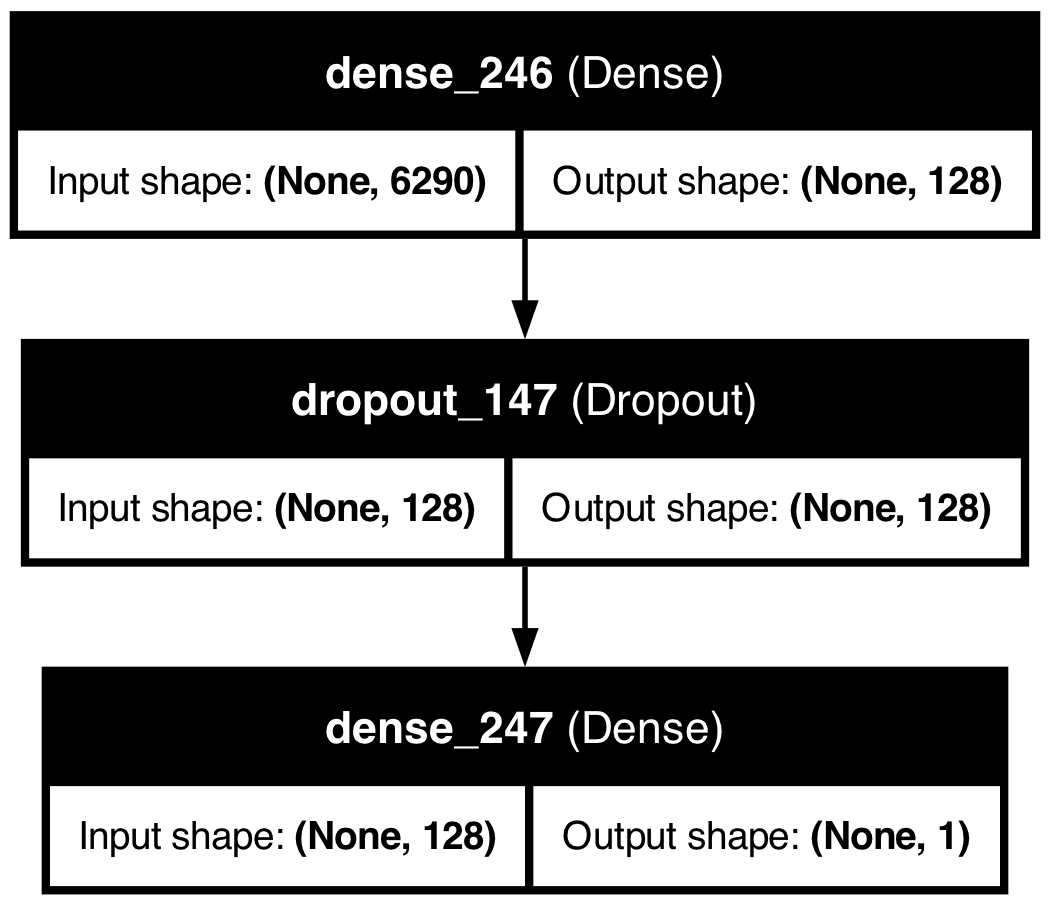

In [37]:
# Generate the plot
plot_model(model_1rTI, show_shapes=True, show_layer_names=True)

Epoch 1/300
246/248 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6172 - loss: 0.8556
Epoch 1: val_loss improved from inf to 0.71378, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6181 - loss: 0.8549 - val_accuracy: 0.7375 - val_loss: 0.7138 - learning_rate: 1.0000e-04
Epoch 2/300
239/248 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7722 - loss: 0.6981
Epoch 2: val_loss improved from 0.71378 to 0.66901, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7722 - loss: 0.6976 - val_accuracy: 0.7562 - val_loss: 0.6690 - learning_rate: 1.0000e-04
Epoch 3/300
243/248 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7732 - loss: 0.6586
Epoch 3: val_loss improved from 0.66901 to 0.64096, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7733 - loss: 0.6585 - val_accuracy: 0.7724 - val_loss: 0.6410 - learning_rate: 1.0000e-04
Epoch 4/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

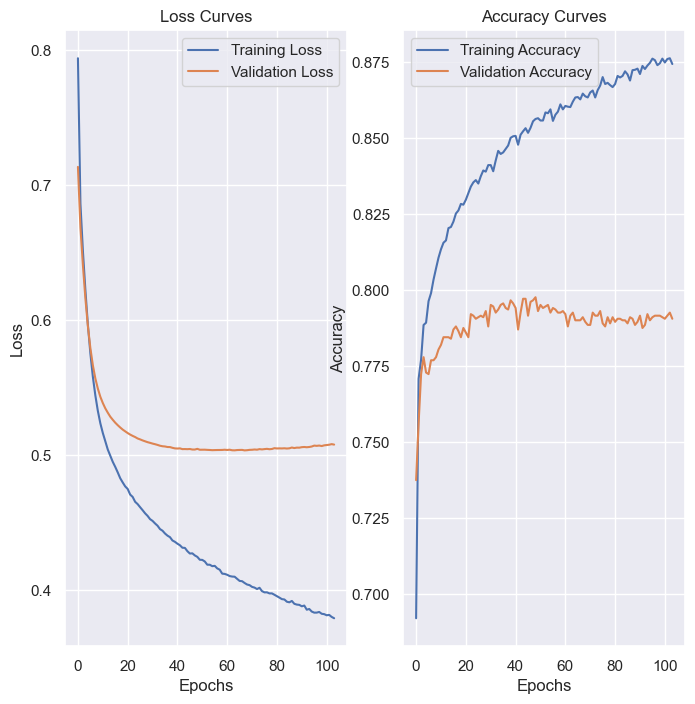

In [38]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_1rTI_history = model_1rTI.fit(
    rX_train_tfidf, ry_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with your model's history
plot_loss_curves(model_1rTI_history)

In [39]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_1rTI.predict(rX_test_tfidf)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1rTI_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m1rTI_accuracy = accuracy_score(ry_test, ry_pred)
m1rTI_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1rTI_recall = recall_score(ry_test, ry_pred, average='weighted')
m1rTI_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1rTI_accuracy:.2%}", f"{m1rTI_precision:.3f}", f"{m1rTI_recall:.3f}", f"{m1rTI_f1:.3f}", f"{m1rTI_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Performance          Results
         accuracy           79.29%
        precision            0.795
           recall            0.793
         f1_score            0.792
    time/instance 0.000185 seconds


In [40]:
store_results('Model_1rTI', m1rTI_accuracy, m1rTI_precision, m1rTI_recall, m1rTI_f1, m1rTI_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.07%     0.782  0.781    0.780  0.000191 seconds
3  Model_1rTI   79.29%     0.795  0.793    0.792  0.000185 seconds


#### Word2Vec Vectorization

In [41]:
# Tokenize reviews
cleaned_train['tokenized_reviews'] = cleaned_train['review'].apply(gensim.utils.simple_preprocess)
cleaned_test['tokenized_reviews'] = cleaned_test['review'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model
word2vec_model_c = Word2Vec(sentences=cleaned_train['tokenized_reviews'], vector_size=250, window=5, min_count=2, workers=4)

# Function to vectorize texts
def vectorize_reviews(reviews, model):
    vectorized = []
    for tokens in reviews:
        # Filter tokens to ensure the model has a vector for them
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            # If there are valid tokens, calculate the mean of their vectors
            review_vec = np.mean([model.wv[token] for token in valid_tokens], axis=0)
        else:
            # If no valid tokens, use a zero vector
            review_vec = np.zeros(model.vector_size)
        vectorized.append(review_vec)
    return np.array(vectorized)


# Vectorize training and testing data
cX_train_vec = vectorize_reviews(cleaned_train['tokenized_reviews'], word2vec_model_c)
cX_test_vec = vectorize_reviews(cleaned_test['tokenized_reviews'], word2vec_model_c)

In [42]:
# Tokenize reviews
raw_train['tokenized_reviews'] = raw_train['review'].apply(gensim.utils.simple_preprocess)
raw_test['tokenized_reviews'] = raw_test['review'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model
word2vec_model_r = Word2Vec(sentences=raw_train['tokenized_reviews'], vector_size=250, window=5, min_count=2, workers=4)

# Function to vectorize texts
def vectorize_reviews(reviews, model):
    vectorized = []
    for tokens in reviews:
        # Filter tokens to ensure the model has a vector for them
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            # If there are valid tokens, calculate the mean of their vectors
            review_vec = np.mean([model.wv[token] for token in valid_tokens], axis=0)
        else:
            # If no valid tokens, use a zero vector
            review_vec = np.zeros(model.vector_size)
        vectorized.append(review_vec)
    return np.array(vectorized)


# Vectorize training and testing data
rX_train_vec = vectorize_reviews(raw_train['tokenized_reviews'], word2vec_model_r)
rX_test_vec = vectorize_reviews(raw_test['tokenized_reviews'], word2vec_model_r)

#### FNN with cleaned data (Word2Vec)

In [43]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(cX_train_vec.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [44]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(cX_train_vec, cy_train, callbacks=[early_stopping])

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5055 - loss: 0.6953
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5421 - loss: 0.6876
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5782 - loss: 0.6782  
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6002 - loss: 0.6721  
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6149 - loss: 0.6634  
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6011 - loss: 0.6623  
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6343 - loss: 0.6476  
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6329 - loss: 0.6465  
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6418 - loss: 0.6391  
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6385 - loss: 0.6335  
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6497 - loss: 0.6300  
Epoch 12/30
206/206 ━━━━━━━━━━━━━━

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5000 - loss: 0.6985
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5449 - loss: 0.6875
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5703 - loss: 0.6791  
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6071 - loss: 0.6703
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6075 - loss: 0.6652  
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6315 - loss: 0.6547
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6246 - loss: 0.6532
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6290 - loss: 0.6461
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6489 - loss: 0.6338  
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6460 - loss: 0.6350
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6618 - loss: 0.6286  
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4878 - loss: 0.6965
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5522 - loss: 0.6859
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5908 - loss: 0.6778  
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.5931 - loss: 0.6708
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.6215 - loss: 0.6580
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6170 - loss: 0.6578
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.6223 - loss: 0.6510
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.6548 - loss: 0.6338
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.6420 - loss: 0.6322
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.6649 - loss: 0.6241
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.6643 - loss: 0.6184
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5062 - loss: 0.8123
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5282 - loss: 0.7273
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.5416 - loss: 0.7094
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.5489 - loss: 0.7015
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5571 - loss: 0.6969  
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5515 - loss: 0.6961  
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.5643 - loss: 0.6937
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.5555 - loss: 0.6942
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.5571 - loss: 0.6907
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.5584 - loss: 0.6915
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.5646 - loss: 0.6909
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 9

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5135 - loss: 0.8183
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5459 - loss: 0.7383
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.5461 - loss: 0.7151
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.5343 - loss: 0.7064
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.5546 - loss: 0.6990
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.5436 - loss: 0.6986
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.5671 - loss: 0.6932
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5555 - loss: 0.6923  
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.5571 - loss: 0.6933
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.5737 - loss: 0.6887
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.5606 - loss: 0.6892
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 9

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4990 - loss: 0.8177
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5257 - loss: 0.7333
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.5481 - loss: 0.7124
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.5615 - loss: 0.7025
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.5548 - loss: 0.6977
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.5633 - loss: 0.6958
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5603 - loss: 0.6922
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5524 - loss: 0.6943
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5620 - loss: 0.6906
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5813 - loss: 0.6872
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5625 - loss: 0.6889
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5159 - loss: 0.6942
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5416 - loss: 0.6896
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5594 - loss: 0.6841
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6004 - loss: 0.6738
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6018 - loss: 0.6674
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6137 - loss: 0.6530
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6254 - loss: 0.6425
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6445 - loss: 0.6299
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6368 - loss: 0.6315
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6496 - loss: 0.6277
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6630 - loss: 0.6172
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5015 - loss: 0.6968
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5356 - loss: 0.6891
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5608 - loss: 0.6820
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5915 - loss: 0.6733
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5978 - loss: 0.6676
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6181 - loss: 0.6546
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6409 - loss: 0.6389
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6451 - loss: 0.6304
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6693 - loss: 0.6175
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6522 - loss: 0.6197
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6901 - loss: 0.6051
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5204 - loss: 0.6944
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5345 - loss: 0.6910
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5719 - loss: 0.6800
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5951 - loss: 0.6708
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6117 - loss: 0.6608
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6286 - loss: 0.6504
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6370 - loss: 0.6400
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6488 - loss: 0.6340
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6507 - loss: 0.6276
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6655 - loss: 0.6150
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6510 - loss: 0.6240
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4931 - loss: 0.8782
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5211 - loss: 0.7403
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5030 - loss: 0.7114
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5195 - loss: 0.7014
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5192 - loss: 0.6970
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5117 - loss: 0.6953
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5112 - loss: 0.6941
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5231 - loss: 0.6934
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5087 - loss: 0.6944
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5104 - loss: 0.6936
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5008 - loss: 0.6939
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5088 - loss: 0.8716
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4996 - loss: 0.7387
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5178 - loss: 0.7095
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5079 - loss: 0.7007
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5162 - loss: 0.6967
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5087 - loss: 0.6949
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5110 - loss: 0.6940
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5070 - loss: 0.6941
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5255 - loss: 0.6931
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5053 - loss: 0.6935
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5265 - loss: 0.6927
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5192 - loss: 0.8753
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5251 - loss: 0.7389
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5062 - loss: 0.7105
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5077 - loss: 0.7009
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5166 - loss: 0.6969
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5193 - loss: 0.6951
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5199 - loss: 0.6939
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5146 - loss: 0.6943
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5247 - loss: 0.6926
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5141 - loss: 0.6934
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5031 - loss: 0.6940
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5134 - loss: 0.6960
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5523 - loss: 0.6843
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5906 - loss: 0.6732
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6070 - loss: 0.6632
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6246 - loss: 0.6531
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6240 - loss: 0.6497
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6499 - loss: 0.6395
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6340 - loss: 0.6401
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6495 - loss: 0.6285
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6503 - loss: 0.6271
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6512 - loss: 0.6215
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5315 - loss: 0.6931
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5628 - loss: 0.6803
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6050 - loss: 0.6723
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6103 - loss: 0.6683
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6119 - loss: 0.6574
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6272 - loss: 0.6499
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6284 - loss: 0.6435
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6437 - loss: 0.6345
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6469 - loss: 0.6342
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6524 - loss: 0.6326
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6573 - loss: 0.6252
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5313 - loss: 0.6933
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5698 - loss: 0.6813
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5960 - loss: 0.6702
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6165 - loss: 0.6603
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6140 - loss: 0.6581
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6481 - loss: 0.6380
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6449 - loss: 0.6369
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6575 - loss: 0.6239
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6568 - loss: 0.6275
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6457 - loss: 0.6241
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6635 - loss: 0.6167
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4952 - loss: 0.8667
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5248 - loss: 0.7356
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5322 - loss: 0.7115
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5485 - loss: 0.7013
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5322 - loss: 0.6993
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5370 - loss: 0.6954
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5446 - loss: 0.6950
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5434 - loss: 0.6948
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5359 - loss: 0.6940
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5403 - loss: 0.6925
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5431 - loss: 0.6948
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4966 - loss: 0.8694
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5390 - loss: 0.7370
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5393 - loss: 0.7132
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5538 - loss: 0.7031
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5446 - loss: 0.6988
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5513 - loss: 0.6943
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5680 - loss: 0.6916
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5462 - loss: 0.6971
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5529 - loss: 0.6941
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5602 - loss: 0.6910
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5539 - loss: 0.6911
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5163 - loss: 0.8631
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5478 - loss: 0.7350
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5182 - loss: 0.7133
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5332 - loss: 0.7031
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5430 - loss: 0.6987
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5637 - loss: 0.6943
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5505 - loss: 0.6948
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5499 - loss: 0.6922
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5472 - loss: 0.6933
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5320 - loss: 0.6940
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5575 - loss: 0.6910
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5081 - loss: 0.6967
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5445 - loss: 0.6900
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5597 - loss: 0.6809
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5935 - loss: 0.6682
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6104 - loss: 0.6581
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6192 - loss: 0.6493
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6373 - loss: 0.6331
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6468 - loss: 0.6318
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6548 - loss: 0.6201
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6538 - loss: 0.6289
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6655 - loss: 0.6124
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5228 - loss: 0.6947
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5391 - loss: 0.6867
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5645 - loss: 0.6805
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6014 - loss: 0.6627
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6079 - loss: 0.6560
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6321 - loss: 0.6407
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6534 - loss: 0.6242
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6573 - loss: 0.6238
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6647 - loss: 0.6191
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6653 - loss: 0.6194
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6609 - loss: 0.6086
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5009 - loss: 0.6975
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5377 - loss: 0.6888
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5767 - loss: 0.6760
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5989 - loss: 0.6669
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6276 - loss: 0.6477
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6409 - loss: 0.6432
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6411 - loss: 0.6301
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6504 - loss: 0.6263
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6597 - loss: 0.6206
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6737 - loss: 0.6075
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6790 - loss: 0.6013
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4975 - loss: 0.9737
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5155 - loss: 0.7448
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5239 - loss: 0.7092
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5103 - loss: 0.6998
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5022 - loss: 0.6961
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5129 - loss: 0.6940
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5156 - loss: 0.6939
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5053 - loss: 0.6939
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5171 - loss: 0.6933
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4986 - loss: 0.6938
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5010 - loss: 0.6940
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5056 - loss: 0.9675
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5099 - loss: 0.7392
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5174 - loss: 0.7055
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4905 - loss: 0.6980
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5052 - loss: 0.6957
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5201 - loss: 0.6937
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5147 - loss: 0.6937
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4968 - loss: 0.6945
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5132 - loss: 0.6941
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5082 - loss: 0.6938
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5188 - loss: 0.6926
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4980 - loss: 0.9693
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5170 - loss: 0.7410
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5170 - loss: 0.7075
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5208 - loss: 0.6972
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5140 - loss: 0.6963
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5132 - loss: 0.6952
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5221 - loss: 0.6936
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5007 - loss: 0.6947
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5147 - loss: 0.6929
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5060 - loss: 0.6938
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5139 - loss: 0.6940
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4925 - loss: 0.6950
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5209 - loss: 0.6925
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5432 - loss: 0.6896
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5429 - loss: 0.6890
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5481 - loss: 0.6890
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5602 - loss: 0.6864  
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5669 - loss: 0.6849
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5575 - loss: 0.6866
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5671 - loss: 0.6829  
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5819 - loss: 0.6820  
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5963 - loss: 0.6807  
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5085 - loss: 0.6933
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5106 - loss: 0.6919  
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5270 - loss: 0.6913
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5273 - loss: 0.6907
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5500 - loss: 0.6895
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5488 - loss: 0.6871  
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5658 - loss: 0.6860
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5738 - loss: 0.6839
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.5903 - loss: 0.6821
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.5926 - loss: 0.6805
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.5800 - loss: 0.6806
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5095 - loss: 0.6941
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5007 - loss: 0.6943
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5303 - loss: 0.6904
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5384 - loss: 0.6892
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.5593 - loss: 0.6883
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.5703 - loss: 0.6864
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.5626 - loss: 0.6860
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.5815 - loss: 0.6848
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.5767 - loss: 0.6829
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.5882 - loss: 0.6809
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.6044 - loss: 0.6793
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 977us

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5014 - loss: 0.8572
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5079 - loss: 0.8275
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5283 - loss: 0.8032
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5318 - loss: 0.7866
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5388 - loss: 0.7731
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5600 - loss: 0.7622
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5566 - loss: 0.7543
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5398 - loss: 0.7475
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5597 - loss: 0.7426
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5688 - loss: 0.7376
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5840 - loss: 0.7325
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4977 - loss: 0.8567
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5197 - loss: 0.8280  
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5315 - loss: 0.8067
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5335 - loss: 0.7916
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5447 - loss: 0.7789
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5490 - loss: 0.7688
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5555 - loss: 0.7595
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5540 - loss: 0.7527
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5684 - loss: 0.7456
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5614 - loss: 0.7426
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5674 - loss: 0.7379
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accura

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4951 - loss: 0.8568
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5291 - loss: 0.8267
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5168 - loss: 0.8062
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5171 - loss: 0.7900
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5457 - loss: 0.7767
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5426 - loss: 0.7658
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5504 - loss: 0.7574
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5552 - loss: 0.7503   
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5431 - loss: 0.7438
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5449 - loss: 0.7414
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5692 - loss: 0.7350
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - acc

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5066 - loss: 0.6935
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5212 - loss: 0.6923
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5318 - loss: 0.6915
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5188 - loss: 0.6917
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5294 - loss: 0.6907
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5490 - loss: 0.6881
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5628 - loss: 0.6862
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5537 - loss: 0.6856
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5917 - loss: 0.6824
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6015 - loss: 0.6791
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5953 - loss: 0.6798
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5033 - loss: 0.6944
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4931 - loss: 0.6944
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5407 - loss: 0.6915
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5342 - loss: 0.6904
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5382 - loss: 0.6898
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5497 - loss: 0.6871
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5654 - loss: 0.6851
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5922 - loss: 0.6829
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5789 - loss: 0.6825
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5967 - loss: 0.6794
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5870 - loss: 0.6785
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5066 - loss: 0.6940
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5093 - loss: 0.6931
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5076 - loss: 0.6929
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5288 - loss: 0.6926
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5371 - loss: 0.6906
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5422 - loss: 0.6894
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5579 - loss: 0.6880
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5694 - loss: 0.6875
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5647 - loss: 0.6857
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5697 - loss: 0.6841
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5811 - loss: 0.6817
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5045 - loss: 0.9365
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5101 - loss: 0.8937
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5159 - loss: 0.8594
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5107 - loss: 0.8324
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5358 - loss: 0.8105
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5181 - loss: 0.7936
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5215 - loss: 0.7800
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5239 - loss: 0.7676
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5294 - loss: 0.7579
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5255 - loss: 0.7507
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5342 - loss: 0.7429
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5055 - loss: 0.9391
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4979 - loss: 0.9004
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5230 - loss: 0.8657
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5228 - loss: 0.8412
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5219 - loss: 0.8206
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5354 - loss: 0.8018
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5292 - loss: 0.7882
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5367 - loss: 0.7765
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5391 - loss: 0.7666
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5575 - loss: 0.7569
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5586 - loss: 0.7498
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4920 - loss: 0.9364
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5154 - loss: 0.8934
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5202 - loss: 0.8602
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5130 - loss: 0.8341
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5256 - loss: 0.8127
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5223 - loss: 0.7955
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5325 - loss: 0.7811
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5319 - loss: 0.7688
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5525 - loss: 0.7586
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5315 - loss: 0.7508
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5471 - loss: 0.7437
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5138 - loss: 0.6934
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5201 - loss: 0.6913
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5225 - loss: 0.6906
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5487 - loss: 0.6884
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5526 - loss: 0.6863
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5699 - loss: 0.6845
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5827 - loss: 0.6822
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6001 - loss: 0.6799
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6019 - loss: 0.6773
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6163 - loss: 0.6757
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6188 - loss: 0.6737
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5008 - loss: 0.6948
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5282 - loss: 0.6916
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5365 - loss: 0.6913
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5468 - loss: 0.6885
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5705 - loss: 0.6847
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5741 - loss: 0.6834
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5753 - loss: 0.6834
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5976 - loss: 0.6801
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5865 - loss: 0.6803
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6086 - loss: 0.6767
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6052 - loss: 0.6763
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4947 - loss: 0.6949
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5134 - loss: 0.6934
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5254 - loss: 0.6901
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5466 - loss: 0.6882
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5530 - loss: 0.6868
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5820 - loss: 0.6830
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5776 - loss: 0.6839
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5767 - loss: 0.6814
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5937 - loss: 0.6791
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6019 - loss: 0.6761
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5854 - loss: 0.6784
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5050 - loss: 0.9346
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5175 - loss: 0.8850
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5093 - loss: 0.8506
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5494 - loss: 0.8218
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5345 - loss: 0.8037
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5476 - loss: 0.7873
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5688 - loss: 0.7726
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5565 - loss: 0.7642
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5564 - loss: 0.7561
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5690 - loss: 0.7501
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5742 - loss: 0.7439
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4962 - loss: 0.9350
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5010 - loss: 0.8817
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5292 - loss: 0.8445
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5168 - loss: 0.8186
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5400 - loss: 0.7972
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5427 - loss: 0.7833
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5405 - loss: 0.7706
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5625 - loss: 0.7608
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5600 - loss: 0.7523
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5621 - loss: 0.7460
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5700 - loss: 0.7412
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4988 - loss: 0.9347
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4982 - loss: 0.8847
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5184 - loss: 0.8475
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5279 - loss: 0.8200
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5339 - loss: 0.7991
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5552 - loss: 0.7817
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5434 - loss: 0.7709
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5584 - loss: 0.7605
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5680 - loss: 0.7532
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5598 - loss: 0.7473
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5689 - loss: 0.7421
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5047 - loss: 0.6934
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5161 - loss: 0.6921
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5203 - loss: 0.6907
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5347 - loss: 0.6892
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5616 - loss: 0.6871
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5777 - loss: 0.6835
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5802 - loss: 0.6809
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5873 - loss: 0.6792
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5997 - loss: 0.6743
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6132 - loss: 0.6647
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6232 - loss: 0.6632
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4773 - loss: 0.6954
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5109 - loss: 0.6927
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5259 - loss: 0.6917
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5383 - loss: 0.6896
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5545 - loss: 0.6882
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5695 - loss: 0.6858
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5885 - loss: 0.6820
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5995 - loss: 0.6797
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5972 - loss: 0.6773
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5965 - loss: 0.6756
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6150 - loss: 0.6735
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5029 - loss: 0.6952
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5154 - loss: 0.6925
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5275 - loss: 0.6923
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5410 - loss: 0.6889
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5656 - loss: 0.6854
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5705 - loss: 0.6845
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5750 - loss: 0.6809
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5807 - loss: 0.6806
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6011 - loss: 0.6758
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6124 - loss: 0.6730
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6147 - loss: 0.6688
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4920 - loss: 1.0952
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5095 - loss: 1.0038
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5266 - loss: 0.9376
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5248 - loss: 0.8876
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5260 - loss: 0.8501
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5473 - loss: 0.8204
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5351 - loss: 0.7997
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5411 - loss: 0.7821
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5429 - loss: 0.7673
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5430 - loss: 0.7564
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5395 - loss: 0.7473
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4955 - loss: 1.0924
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5185 - loss: 1.0011
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5311 - loss: 0.9346
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5210 - loss: 0.8843
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5325 - loss: 0.8460
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5316 - loss: 0.8170
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5284 - loss: 0.7952
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5341 - loss: 0.7770
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5379 - loss: 0.7632
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5515 - loss: 0.7514
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5279 - loss: 0.7446
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5142 - loss: 1.0923
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5001 - loss: 1.0042
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5278 - loss: 0.9359
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5225 - loss: 0.8863
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5243 - loss: 0.8477
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5276 - loss: 0.8198
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5360 - loss: 0.7968
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5485 - loss: 0.7793
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5326 - loss: 0.7657
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5469 - loss: 0.7542
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5510 - loss: 0.7454
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5276 - loss: 0.6941
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5609 - loss: 0.6799
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6070 - loss: 0.6649
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6296 - loss: 0.6451
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6486 - loss: 0.6272
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6605 - loss: 0.6175
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6572 - loss: 0.6185
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6755 - loss: 0.6045
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6765 - loss: 0.6039
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6844 - loss: 0.5971
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6754 - loss: 0.6002
Epoch 12/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

In [45]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.718231 using {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.711351 (0.007983) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.623121 (0.054612) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.714183 (0.009153) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.510319 (0.011014) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.711149 (0.006485) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.574268 (0.047315) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.718231 (0.006028) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.506981 (0.002602) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.653481 (0.005363) with: {'learning_rate': 

In [46]:
# Extract the best parameters
best_params = grid_result.best_params_

In [47]:
# Create the final model using the best parameters
model_1cWV = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_1cWV.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_371 (Dense)               │ (None, 256)            │        64,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_222 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_372 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_223 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_373 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,281 (380.00 KB)

 Trainable params: 97,281 (380.00 KB)

 Non-trainable params: 0 (0.00 B)

None


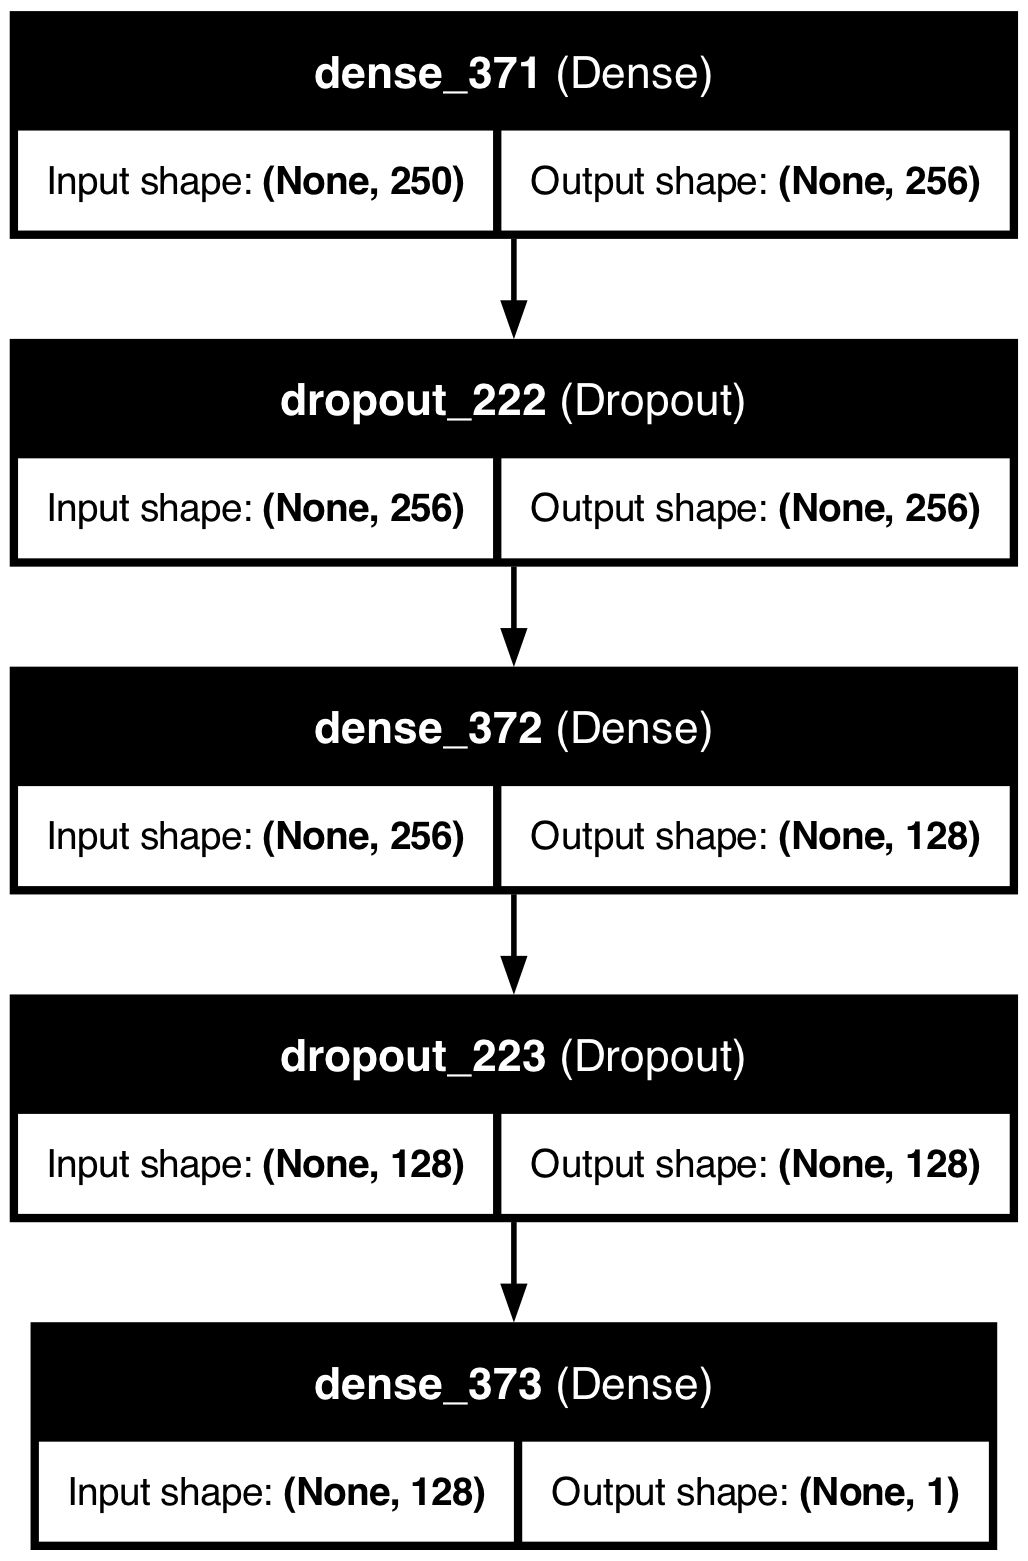

In [48]:
# Generate the plot
plot_model(model_1cWV, show_shapes=True, show_layer_names=True)

Epoch 1/300
240/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5003 - loss: 0.6962
Epoch 1: val_loss improved from inf to 0.68410, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5007 - loss: 0.6961 - val_accuracy: 0.5225 - val_loss: 0.6841 - learning_rate: 0.0010
Epoch 2/300
226/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5559 - loss: 0.6866
Epoch 2: val_loss did not improve from 0.68410
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5568 - loss: 0.6863 - val_accuracy: 0.5215 - val_loss: 0.6865 - learning_rate: 0.0010
Epoch 3/300
241/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5741 - loss: 0.6786
Epoch 3: val_loss improved from 0.68410 to 0.67620, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5748 - loss: 0.6783 - val_accuracy: 0.5766 - val_loss: 0.6762 - learning_rate: 0.0010
Epoch 4/300
242/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6200 - loss: 0.6578
Epoch 4: val_los

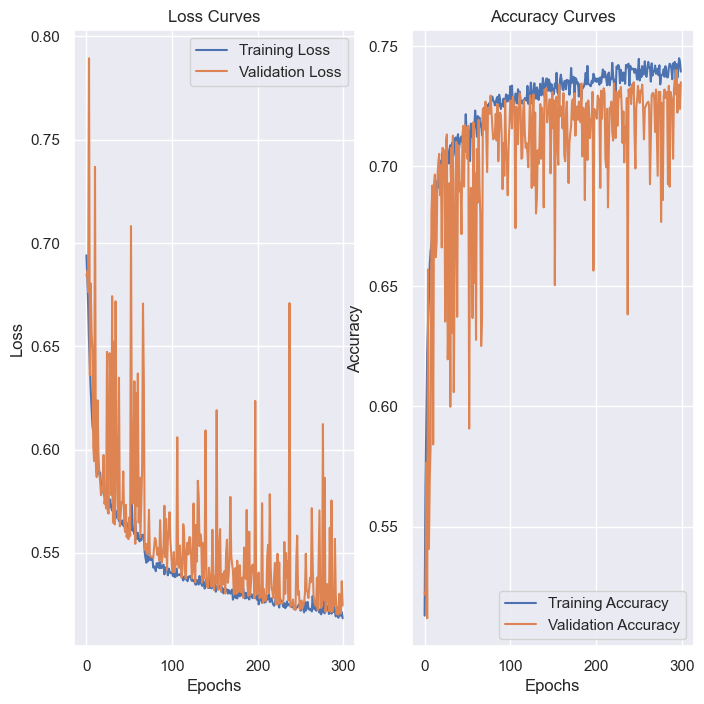

In [49]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_1cWV_history = model_1cWV.fit(
    cX_train_vec, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with model's history
plot_loss_curves(model_1cWV_history)

In [50]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_1cWV.predict(cX_test_vec)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1cWV_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate accuracy, precision, recall, and f1 score
m1cWV_accuracy = accuracy_score(cy_test, cy_pred)
m1cWV_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1cWV_recall = recall_score(cy_test, cy_pred, average='weighted')
m1cWV_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1cWV_accuracy:.2%}", f"{m1cWV_precision:.3f}", f"{m1cWV_recall:.3f}", f"{m1cWV_f1:.3f}", f"{m1cWV_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model Performance          Results
         accuracy           74.96%
        precision            0.753
           recall            0.750
         f1_score            0.749
    time/instance 0.000129 seconds


In [51]:
store_results('Model_1cWV', m1cWV_accuracy, m1cWV_precision, m1cWV_recall, m1cWV_f1, m1cWV_time_per_instance)

# View the consolidated results
print(results_df)

        Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0cTI   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0rTI   78.92%     0.795  0.789    0.788  0.000000 seconds
2  Model_1cTI   78.07%     0.782  0.781    0.780  0.000191 seconds
3  Model_1rTI   79.29%     0.795  0.793    0.792  0.000185 seconds
4  Model_1cWV   74.96%     0.753  0.750    0.749  0.000129 seconds


#### FNN with raw data (Word2Vec)

In [52]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(rX_train_vec.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [53]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)

# Execute the grid search with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
grid_result = grid.fit(rX_train_vec, ry_train, callbacks=[early_stopping])

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/30


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5657 - loss: 0.6789
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6180 - loss: 0.6535
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6441 - loss: 0.6368  
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6437 - loss: 0.6295  
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.6445 - loss: 0.6223
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6549 - loss: 0.6224
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6455 - loss: 0.6210  
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6694 - loss: 0.6147
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6631 - loss: 0.6148  
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6598 - loss: 0.6140
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6665 - loss: 0.6086  
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5676 - loss: 0.6769
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.6093 - loss: 0.6575
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6315 - loss: 0.6421  
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.6408 - loss: 0.6325
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6519 - loss: 0.6255
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.6451 - loss: 0.6296
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.6755 - loss: 0.6088
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6736 - loss: 0.6110   
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.6582 - loss: 0.6120
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.6656 - loss: 0.6123
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.6666 - loss: 0.6117
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5636 - loss: 0.6747
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6311 - loss: 0.6463
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.6339 - loss: 0.6376
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.6510 - loss: 0.6235
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.6615 - loss: 0.6170
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6479 - loss: 0.6179  
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.6685 - loss: 0.6082
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.6633 - loss: 0.6056
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.6670 - loss: 0.6037
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.6834 - loss: 0.6034
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.6756 - loss: 0.5998
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 9

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5629 - loss: 0.8102
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6196 - loss: 0.7157
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.6374 - loss: 0.6849
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.6223 - loss: 0.6759
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.6270 - loss: 0.6658
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - accuracy: 0.6393 - loss: 0.6624
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.6380 - loss: 0.6583
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6401 - loss: 0.6595
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.6385 - loss: 0.6540
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.6440 - loss: 0.6548
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.6410 - loss: 0.6481
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 969

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5457 - loss: 0.8091
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6043 - loss: 0.7122
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6094 - loss: 0.6909
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6286 - loss: 0.6737
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6419 - loss: 0.6660
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6285 - loss: 0.6638
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6293 - loss: 0.6650
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6541 - loss: 0.6522
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6367 - loss: 0.6521  
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.6400 - loss: 0.6535
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.6445 - loss: 0.6491
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5586 - loss: 0.8084
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6107 - loss: 0.7173
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.6071 - loss: 0.6896
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.6368 - loss: 0.6713
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.6421 - loss: 0.6688
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.6275 - loss: 0.6655
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.6420 - loss: 0.6589
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.6468 - loss: 0.6494
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.6419 - loss: 0.6514
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.6515 - loss: 0.6489
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.6323 - loss: 0.6516
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 9

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5534 - loss: 0.6800
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6339 - loss: 0.6497
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6317 - loss: 0.6425
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6418 - loss: 0.6345
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6472 - loss: 0.6217
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6605 - loss: 0.6164
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6680 - loss: 0.6113
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6665 - loss: 0.6080
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6607 - loss: 0.6104
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6660 - loss: 0.6088
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6576 - loss: 0.6125
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5657 - loss: 0.6767
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6090 - loss: 0.6577
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6322 - loss: 0.6404
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6525 - loss: 0.6246
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6384 - loss: 0.6253
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6562 - loss: 0.6199
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6596 - loss: 0.6169
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6648 - loss: 0.6118
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6674 - loss: 0.6112
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6847 - loss: 0.5924
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6726 - loss: 0.6045
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5669 - loss: 0.6789
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6144 - loss: 0.6533
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6353 - loss: 0.6377
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6342 - loss: 0.6328
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6663 - loss: 0.6137
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6522 - loss: 0.6161
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6622 - loss: 0.6091
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6784 - loss: 0.5994
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6664 - loss: 0.6008
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6675 - loss: 0.6050
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6684 - loss: 0.6033
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5575 - loss: 0.8697
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6015 - loss: 0.7339
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6153 - loss: 0.6984
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6145 - loss: 0.6792
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6242 - loss: 0.6742
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6334 - loss: 0.6695
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6346 - loss: 0.6617
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6381 - loss: 0.6574
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6319 - loss: 0.6569
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6274 - loss: 0.6661
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6394 - loss: 0.6529
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5600 - loss: 0.8742
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6136 - loss: 0.7342
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6305 - loss: 0.6974
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6221 - loss: 0.6855
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6370 - loss: 0.6707
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6412 - loss: 0.6651
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6363 - loss: 0.6606
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6265 - loss: 0.6647
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6336 - loss: 0.6600
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6519 - loss: 0.6482
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6557 - loss: 0.6471
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5509 - loss: 0.8780
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6019 - loss: 0.7430
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6092 - loss: 0.7037
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6290 - loss: 0.6824
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6232 - loss: 0.6728
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6382 - loss: 0.6629
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6369 - loss: 0.6618
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6394 - loss: 0.6577
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6417 - loss: 0.6524
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6508 - loss: 0.6478
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6481 - loss: 0.6438
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5736 - loss: 0.6732
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6165 - loss: 0.6480
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6344 - loss: 0.6361
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6324 - loss: 0.6330
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6539 - loss: 0.6181
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6475 - loss: 0.6217
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6543 - loss: 0.6192
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6554 - loss: 0.6125
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6597 - loss: 0.6113
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6617 - loss: 0.6067
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6576 - loss: 0.6139
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5803 - loss: 0.6743
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6280 - loss: 0.6453
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6498 - loss: 0.6283
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6458 - loss: 0.6276
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6583 - loss: 0.6216
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6577 - loss: 0.6187
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6582 - loss: 0.6098
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6610 - loss: 0.6157
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6697 - loss: 0.6048
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6804 - loss: 0.5993
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6541 - loss: 0.6107
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5653 - loss: 0.6771
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6404 - loss: 0.6424
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6414 - loss: 0.6371
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6463 - loss: 0.6275
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6523 - loss: 0.6210
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6494 - loss: 0.6169
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6593 - loss: 0.6083
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6684 - loss: 0.6085
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6600 - loss: 0.6059
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6713 - loss: 0.6027
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6737 - loss: 0.6024
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5718 - loss: 0.8508
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6142 - loss: 0.7106
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6262 - loss: 0.6853
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6273 - loss: 0.6748
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6187 - loss: 0.6714
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6325 - loss: 0.6642
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6388 - loss: 0.6587
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6279 - loss: 0.6561
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6334 - loss: 0.6576
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6328 - loss: 0.6600
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6371 - loss: 0.6566
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5793 - loss: 0.8569
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6099 - loss: 0.7251
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6279 - loss: 0.6865
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6183 - loss: 0.6756
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6266 - loss: 0.6672
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6279 - loss: 0.6620
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6347 - loss: 0.6607
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6432 - loss: 0.6554
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6463 - loss: 0.6498
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6312 - loss: 0.6584
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6395 - loss: 0.6554
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5649 - loss: 0.8618
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5977 - loss: 0.7237
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6302 - loss: 0.6852
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6229 - loss: 0.6726
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6246 - loss: 0.6662
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6233 - loss: 0.6655
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6340 - loss: 0.6576
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6256 - loss: 0.6618
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6409 - loss: 0.6497
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6384 - loss: 0.6497
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6442 - loss: 0.6478
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5780 - loss: 0.6799
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6233 - loss: 0.6505
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6428 - loss: 0.6255
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6585 - loss: 0.6231
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6670 - loss: 0.6125
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6531 - loss: 0.6205
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6628 - loss: 0.6136
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6577 - loss: 0.6186
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6748 - loss: 0.6053
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6740 - loss: 0.5965
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6737 - loss: 0.6022
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5712 - loss: 0.6762
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6115 - loss: 0.6555
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6490 - loss: 0.6288
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6504 - loss: 0.6273
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6632 - loss: 0.6145
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6671 - loss: 0.6061
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6498 - loss: 0.6182
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6691 - loss: 0.6070
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6742 - loss: 0.6035
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6545 - loss: 0.6196
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6727 - loss: 0.6099
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5669 - loss: 0.6767
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6383 - loss: 0.6426
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6407 - loss: 0.6347
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6417 - loss: 0.6246
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6508 - loss: 0.6224
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6564 - loss: 0.6135
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6555 - loss: 0.6080
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6678 - loss: 0.6040
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6648 - loss: 0.6059
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6836 - loss: 0.5946
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6719 - loss: 0.5973
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5620 - loss: 0.9683
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6124 - loss: 0.7438
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6169 - loss: 0.7009
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6156 - loss: 0.6783
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6220 - loss: 0.6774
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6248 - loss: 0.6636
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6513 - loss: 0.6596
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6276 - loss: 0.6642
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6458 - loss: 0.6527
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6376 - loss: 0.6585
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6417 - loss: 0.6550
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5583 - loss: 0.9700
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6040 - loss: 0.7429
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6191 - loss: 0.6987
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6281 - loss: 0.6770
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6361 - loss: 0.6664
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6401 - loss: 0.6614
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6438 - loss: 0.6561
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6389 - loss: 0.6605
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6424 - loss: 0.6574
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6586 - loss: 0.6479
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6384 - loss: 0.6524
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5494 - loss: 0.9802
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6201 - loss: 0.7407
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6214 - loss: 0.6975
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6332 - loss: 0.6758
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6214 - loss: 0.6706
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6306 - loss: 0.6683
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6280 - loss: 0.6631
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6613 - loss: 0.6502
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6581 - loss: 0.6445
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6476 - loss: 0.6504
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6450 - loss: 0.6511
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5380 - loss: 0.6902
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5804 - loss: 0.6759
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.5925 - loss: 0.6684
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.5911 - loss: 0.6664
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.6141 - loss: 0.6607
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.6150 - loss: 0.6549
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.6089 - loss: 0.6623
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.6291 - loss: 0.6522
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.6300 - loss: 0.6513
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.6332 - loss: 0.6491
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.6365 - loss: 0.6449
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 9

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5292 - loss: 0.6893
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5856 - loss: 0.6743
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.6112 - loss: 0.6645
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.6022 - loss: 0.6594
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.6215 - loss: 0.6559
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.6257 - loss: 0.6552
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.6264 - loss: 0.6530
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.6155 - loss: 0.6544
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.6273 - loss: 0.6477
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.6215 - loss: 0.6537
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.6411 - loss: 0.6431
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 9

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5092 - loss: 0.6939
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5779 - loss: 0.6757
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.6000 - loss: 0.6682
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.5944 - loss: 0.6652
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.6135 - loss: 0.6596
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.6141 - loss: 0.6550
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.6156 - loss: 0.6583
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.6193 - loss: 0.6541
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.6274 - loss: 0.6523
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.6174 - loss: 0.6520
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.6385 - loss: 0.6440
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 9

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5025 - loss: 0.8577
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5916 - loss: 0.8161
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.6035 - loss: 0.7937
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.5993 - loss: 0.7778
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.6029 - loss: 0.7641
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.6054 - loss: 0.7537
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.6244 - loss: 0.7405
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.6252 - loss: 0.7282
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.6168 - loss: 0.7276
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.6258 - loss: 0.7204
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6372 - loss: 0.7114  
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 9

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5257 - loss: 0.8559
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5922 - loss: 0.8198
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.5931 - loss: 0.7962
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.6080 - loss: 0.7762
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.6258 - loss: 0.7613
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.6328 - loss: 0.7475
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.6209 - loss: 0.7401
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6171 - loss: 0.7336
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6129 - loss: 0.7347
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6196 - loss: 0.7257
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6247 - loss: 0.7191
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5156 - loss: 0.8550
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5726 - loss: 0.8205
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.5946 - loss: 0.7954
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.6076 - loss: 0.7775
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.6127 - loss: 0.7610
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.6017 - loss: 0.7559
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.6213 - loss: 0.7396
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.6150 - loss: 0.7355
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.6297 - loss: 0.7243
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.6232 - loss: 0.7253
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.6250 - loss: 0.7156
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5269 - loss: 0.6892
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5937 - loss: 0.6742
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5941 - loss: 0.6704
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6049 - loss: 0.6641
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6092 - loss: 0.6605
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6191 - loss: 0.6557
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6113 - loss: 0.6582
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6377 - loss: 0.6450
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6325 - loss: 0.6465
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6334 - loss: 0.6454
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6339 - loss: 0.6445
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5253 - loss: 0.6910
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5957 - loss: 0.6745
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5968 - loss: 0.6686
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6147 - loss: 0.6624
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6054 - loss: 0.6622
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6144 - loss: 0.6578
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6204 - loss: 0.6557
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6241 - loss: 0.6530
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6396 - loss: 0.6442
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6359 - loss: 0.6420
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6447 - loss: 0.6384
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5257 - loss: 0.6904
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5690 - loss: 0.6792
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6041 - loss: 0.6693
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6007 - loss: 0.6649
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6069 - loss: 0.6592
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6155 - loss: 0.6584
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6225 - loss: 0.6515
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6299 - loss: 0.6514
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6365 - loss: 0.6509
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6440 - loss: 0.6414
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6406 - loss: 0.6436
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5279 - loss: 0.9383
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5846 - loss: 0.8918
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6027 - loss: 0.8536
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6147 - loss: 0.8258
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6055 - loss: 0.8085
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6195 - loss: 0.7864
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6132 - loss: 0.7755
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6228 - loss: 0.7581
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6255 - loss: 0.7504
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6111 - loss: 0.7477
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6233 - loss: 0.7394
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5106 - loss: 0.9376
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5858 - loss: 0.8872
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5937 - loss: 0.8535
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5991 - loss: 0.8255
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6071 - loss: 0.8035
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6163 - loss: 0.7865
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6090 - loss: 0.7719
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6089 - loss: 0.7623
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6201 - loss: 0.7525
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6364 - loss: 0.7415
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6329 - loss: 0.7326
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5203 - loss: 0.9378
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5763 - loss: 0.8916
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5873 - loss: 0.8561
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5846 - loss: 0.8303
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5960 - loss: 0.8085
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5990 - loss: 0.7936
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6171 - loss: 0.7717
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6160 - loss: 0.7635
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6188 - loss: 0.7518
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6249 - loss: 0.7414
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6279 - loss: 0.7379
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5497 - loss: 0.6869
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5957 - loss: 0.6727
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6097 - loss: 0.6598
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6192 - loss: 0.6567
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6136 - loss: 0.6580
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6195 - loss: 0.6545
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6344 - loss: 0.6468
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6332 - loss: 0.6476
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6424 - loss: 0.6433
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6333 - loss: 0.6431
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6492 - loss: 0.6378
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5440 - loss: 0.6883
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5928 - loss: 0.6684
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6177 - loss: 0.6627
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6041 - loss: 0.6575
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6283 - loss: 0.6509
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6223 - loss: 0.6535
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6398 - loss: 0.6461
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6224 - loss: 0.6518
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6382 - loss: 0.6442
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6479 - loss: 0.6389
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6442 - loss: 0.6390
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5321 - loss: 0.6904
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5958 - loss: 0.6691
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5971 - loss: 0.6619
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6086 - loss: 0.6578
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6127 - loss: 0.6541
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6353 - loss: 0.6526
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6374 - loss: 0.6419
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6222 - loss: 0.6489
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6301 - loss: 0.6444
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6378 - loss: 0.6407
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6401 - loss: 0.6393
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5516 - loss: 0.9286
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6006 - loss: 0.8691
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6149 - loss: 0.8276
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6178 - loss: 0.8019
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6074 - loss: 0.7829
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6299 - loss: 0.7619
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6145 - loss: 0.7504
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6233 - loss: 0.7426
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6248 - loss: 0.7338
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6313 - loss: 0.7247
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6151 - loss: 0.7226
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5233 - loss: 0.9327
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6056 - loss: 0.8752
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6009 - loss: 0.8419
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6223 - loss: 0.8079
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6180 - loss: 0.7894
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6220 - loss: 0.7729
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6025 - loss: 0.7663
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6161 - loss: 0.7517
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6242 - loss: 0.7415
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6390 - loss: 0.7337
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6348 - loss: 0.7220
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5466 - loss: 0.9276
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5853 - loss: 0.8709
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5928 - loss: 0.8340
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5926 - loss: 0.8086
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6124 - loss: 0.7820
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6231 - loss: 0.7659
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6265 - loss: 0.7515
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6270 - loss: 0.7433
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6333 - loss: 0.7278
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6290 - loss: 0.7254
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6340 - loss: 0.7206
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5504 - loss: 0.6851
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5934 - loss: 0.6706
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5978 - loss: 0.6660
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6063 - loss: 0.6592
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6222 - loss: 0.6534
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6300 - loss: 0.6490
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6221 - loss: 0.6486
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6332 - loss: 0.6405
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6360 - loss: 0.6384
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6423 - loss: 0.6379
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6427 - loss: 0.6340
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5213 - loss: 0.6901
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5940 - loss: 0.6733
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5991 - loss: 0.6658
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6189 - loss: 0.6568
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6257 - loss: 0.6575
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6249 - loss: 0.6513
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6398 - loss: 0.6425
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6375 - loss: 0.6440
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6450 - loss: 0.6392
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6488 - loss: 0.6338
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6650 - loss: 0.6270
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5361 - loss: 0.6879
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5965 - loss: 0.6695
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6202 - loss: 0.6555
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6168 - loss: 0.6532
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6234 - loss: 0.6501
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6282 - loss: 0.6500
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6329 - loss: 0.6423
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6489 - loss: 0.6414
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6458 - loss: 0.6288
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6544 - loss: 0.6266
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6421 - loss: 0.6303
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5216 - loss: 1.0932
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5958 - loss: 1.0010
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5992 - loss: 0.9361
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5983 - loss: 0.8931
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6157 - loss: 0.8567
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6171 - loss: 0.8265
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6192 - loss: 0.8015
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6359 - loss: 0.7848
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6245 - loss: 0.7754
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6340 - loss: 0.7626
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6311 - loss: 0.7472
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5289 - loss: 1.0902
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5817 - loss: 1.0016
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6059 - loss: 0.9357
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6092 - loss: 0.8922
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6271 - loss: 0.8535
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6225 - loss: 0.8298
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6193 - loss: 0.8106
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6364 - loss: 0.7848
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6347 - loss: 0.7741
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6351 - loss: 0.7593
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6498 - loss: 0.7455
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5248 - loss: 1.0922
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5850 - loss: 1.0036
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5929 - loss: 0.9400
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6168 - loss: 0.8861
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6048 - loss: 0.8561
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6114 - loss: 0.8273
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6133 - loss: 0.8023
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6188 - loss: 0.7849
Epoch 9/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6337 - loss: 0.7703
Epoch 10/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6274 - loss: 0.7596
Epoch 11/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6363 - loss: 0.7456
Epoch 12/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5672 - loss: 0.6744
Epoch 2/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6246 - loss: 0.6514
Epoch 3/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6548 - loss: 0.6248
Epoch 4/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6647 - loss: 0.6185
Epoch 5/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6609 - loss: 0.6139
Epoch 6/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6676 - loss: 0.6064
Epoch 7/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6661 - loss: 0.6057
Epoch 8/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6740 - loss: 0.6018
Epoch 9/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6803 - loss: 0.5980
Epoch 10/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6740 - loss: 0.6046
Epoch 11/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6825 - loss: 0.5931
Epoch 12/30
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

In [54]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.703358 using {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.684035 (0.014630) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0}
0.659956 (0.015339) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 1, 'regularization': 0.001}
0.703358 (0.008904) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0}
0.681505 (0.002485) with: {'learning_rate': 0.001, 'neurons': 128, 'num_layers': 2, 'regularization': 0.001}
0.699209 (0.011814) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0}
0.666634 (0.005545) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 1, 'regularization': 0.001}
0.692029 (0.007822) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0}
0.657631 (0.030018) with: {'learning_rate': 0.001, 'neurons': 256, 'num_layers': 2, 'regularization': 0.001}
0.662081 (0.008927) with: {'learning_rate': 

In [55]:
# Extract the best parameters
best_params = grid_result.best_params_

In [56]:
# Create the final model using the best parameters
model_1rWV = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_1rWV.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_199"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_497 (Dense)               │ (None, 128)            │        32,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_298 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_498 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_299 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_499 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,449 (158.00 KB)

 Trainable params: 40,449 (158.00 KB)

 Non-trainable params: 0 (0.00 B)

None


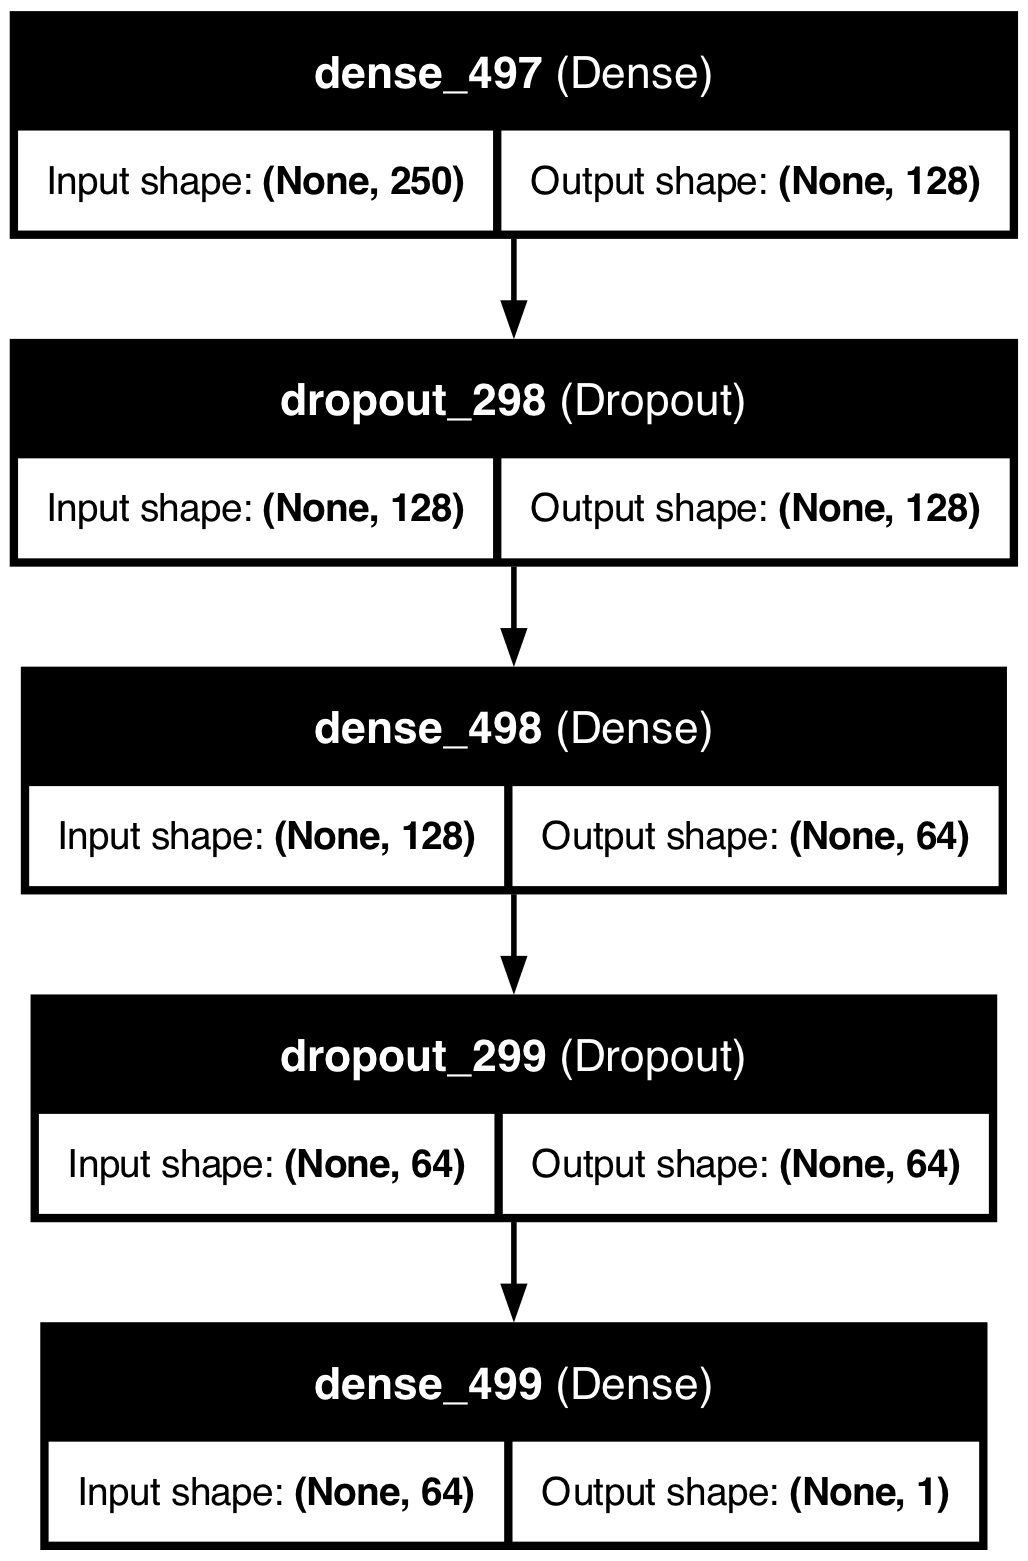

In [57]:
# Generate the plot
plot_model(model_1rWV, show_shapes=True, show_layer_names=True)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_1rWV_history = model_1rWV.fit(
    rX_train_vec, ry_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with model's history
plot_loss_curves(model_1rWV_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_1rWV.predict(rX_test_vec)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1rWV_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m1rWV_accuracy = accuracy_score(ry_test, ry_pred)
m1rWV_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1rWV_recall = recall_score(ry_test, ry_pred, average='weighted')
m1rWV_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1rWV_accuracy:.2%}", f"{m1rWV_precision:.3f}", f"{m1rWV_recall:.3f}", f"{m1rWV_f1:.3f}", f"{m1rWV_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

In [ ]:
store_results('Model_1rWV', m1rWV_accuracy, m1rWV_precision, m1rWV_recall, m1rWV_f1, m1rWV_time_per_instance)

# View the consolidated results
print(results_df)

### LSTM (single layer)

My second model is a LSTM with a single layer

#### LSTM reshaping

In [ ]:
# Initialize the tokenizer
tokenizer = Tokenizer()
# Fit the tokenizer on your training data
tokenizer.fit_on_texts(cX_train)
# Convert texts to sequences
cx_train_seq = tokenizer.texts_to_sequences(cX_train)
cx_test_seq = tokenizer.texts_to_sequences(cX_test)
# Get the word index
word_index = tokenizer.word_index
# Vocabulary size
vocab_sizeC = len(word_index) + 1
print("Vocab size:", vocab_sizeC)
# Determine the length of each sequence
sequence_lengths = [len(seq) for seq in cx_train_seq]
# Calculate the 95th percentile of sequence lengths
max_lengthC = int(np.percentile(sequence_lengths, 95))
print("Max length:", max_lengthC)
# Pad sequences to ensure uniform length
padded_sequences = pad_sequences(cx_train_seq, maxlen=max_lengthC, padding='post')
padded_sequencesT = pad_sequences(cx_test_seq, maxlen=max_lengthC, padding='post')
# The training data is now padded_sequences
cX_train_pad = padded_sequences
cX_test_pad = padded_sequencesT
# Print padded sequences
print("Padded sequences:", cX_train_pad)
cX_train_lstm = cX_train_pad  # Preprocessed input data for the LSTM model
cX_test_lstm = cX_test_pad  # Preprocessed input data for the LSTM model

In [ ]:
# Initialize the tokenizer
tokenizer = Tokenizer()
# Fit the tokenizer on your training data
tokenizer.fit_on_texts(rX_train)
# Convert texts to sequences
rx_train_seq = tokenizer.texts_to_sequences(rX_train)
rx_test_seq = tokenizer.texts_to_sequences(rX_test)
# Get the word index
word_index = tokenizer.word_index
# Vocabulary size
vocab_sizeR = len(word_index) + 1
print("Vocab size:", vocab_sizeR)  
# Determine the length of each sequence
sequence_lengths = [len(seq) for seq in rx_train_seq]
# Calculate the 95th percentile of sequence lengths
max_lengthR = int(np.percentile(sequence_lengths, 95))
print("Max length:", max_lengthR)
# Pad sequences to ensure uniform length
padded_sequences = pad_sequences(rx_train_seq, maxlen=max_lengthR, padding='post')
padded_sequencesT = pad_sequences(rx_test_seq, maxlen=max_lengthR, padding='post')
# The training data is now padded_sequences
rX_train_pad = padded_sequences
rX_test_pad = padded_sequencesT
# Print padded sequences
print("Padded sequences:", rX_train_pad)
rX_train_lstm = rX_train_pad  # Preprocessed input data for the LSTM model
rX_test_lstm = rX_test_pad  # Preprocessed input data for the LSTM model


#### LSTM (single layer) with cleaned data

In [ ]:
def create_model(input_length=max_lengthC, input_dim=vocab_sizeC, output_dim=128, lstm_units=128, dropout_rate=0.5, regularization=0.005, learning_rate=0.001):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(inputs)
    x = LSTM(units=lstm_units, kernel_regularizer=l2(regularization))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


def create_model_wrapper(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate):
    return create_model(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate)

# Wrap the model with KerasClassifier from scikeras
model = KerasClassifier(
    model=create_model_wrapper,
    input_length=max_lengthC,
    input_dim=vocab_sizeC,
    output_dim=64,
    lstm_units=128,
    dropout_rate=0.5,
    regularization=0.005,
    learning_rate=0.001,
    epochs=10,
    batch_size=32,
    verbose=1
)

# Define the grid search parameters
param_grid = {
    'lstm_units': [256,512],  # Focused values for LSTM units
    'learning_rate': [0.001,0.0001],  # Narrow range for learning rate
    'output_dim': [128,256]  # Output dimensions of Embedding layer
}

# Fit the model directly without GridSearchCV
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the grid search
grid_result = grid.fit(cX_train_lstm, cy_train, callbacks=[early_stopping])

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_2cIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    output_dim=best_params['output_dim']
)

# Model Summary
print(model_2cIT.summary())

In [ ]:
# Generate the plot
plot_model(model_2cIT, show_shapes=True, show_layer_names=True)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_2cIT_history = model_2cIT.fit(
    cX_train_lstm, cy_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

In [ ]:
# Use the function with your model's history
plot_loss_curves(model_2cIT_history) 

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_2cIT.predict(cX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m2cIT_time_per_instance = (end_time - start_time) / len(cX_test_lstm)

# Calculate accuracy, precision, recall, and f1 score
m2cIT_accuracy = accuracy_score(cy_test, cy_pred)
m2cIT_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m2cIT_recall = recall_score(cy_test, cy_pred, average='weighted')
m2cIT_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m2cIT_accuracy:.2%}", f"{m2cIT_precision:.3f}", f"{m2cIT_recall:.3f}", f"{m2cIT_f1:.3f}", f"{m2cIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

In [ ]:
store_results('Model_2c', m2cIT_accuracy, m2cIT_precision, m2cIT_recall, m2cIT_f1, m2cIT_time_per_instance)

# View the consolidated results
print(results_df)

#### LSTM (single layer) with raw data

In [ ]:
def create_model(input_length=max_lengthR, input_dim=vocab_sizeR, output_dim=128, lstm_units=128, dropout_rate=0.5, regularization=0.005, learning_rate=0.005):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(inputs)
    x = LSTM(units=lstm_units, kernel_regularizer=l2(regularization))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


def create_model_wrapper(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate):
    return create_model(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate)

# Wrap the model with KerasClassifier from scikeras
model = KerasClassifier(
    model=create_model_wrapper,
    input_length=max_lengthR,
    input_dim=vocab_sizeR,
    output_dim=64,
    lstm_units=128,
    dropout_rate=0.5,
    regularization=0.005,
    learning_rate=0.001,
    epochs=10,
    batch_size=32,
    verbose=1
)

# Fit the model directly without GridSearchCV
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the grid search
#grid_result = grid.fit(rX_train_lstm, ry_train, callbacks=[early_stopping])

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_2rIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    output_dim=best_params['output_dim']
)

# Model Summary
print(model_2rIT.summary())

In [ ]:
# Generate the plot
plot_model(model_2rIT, show_shapes=True, show_layer_names=True)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_2rIT_history = model_2rIT.fit(
    rX_train_lstm, ry_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with the model's history
plot_loss_curves(model_2rIT_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_2rIT.predict(rX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob> 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m2rIT_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m2rIT_accuracy = accuracy_score(ry_test, ry_pred)
m2rIT_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m2rIT_recall = recall_score(ry_test, ry_pred, average='weighted')
m2rIT_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m2rIT_accuracy:.2%}", f"{m2rIT_precision:.3f}", f"{m2rIT_recall:.3f}", f"{m2rIT_f1:.3f}", f"{m2rIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

In [ ]:
store_results('Model_2r', m2rIT_accuracy, m2rIT_precision, m2rIT_recall, m2rIT_f1, m2rIT_time_per_instance)

# View the consolidated results
print(results_df)

### LSTM (stacked)

Now I use another LSTM (LSTM stacked)

#### LSTM (stacked) with cleaned data

In [ ]:
def create_model(input_length=max_lengthC, input_dim=vocab_sizeC, output_dim=128, lstm_units=128, dropout_rate=0.5, regularization=0.005, learning_rate=0.001):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(inputs)
    x = LSTM(units=lstm_units, return_sequences=True, kernel_regularizer=l2(regularization))(x)
    x = Dropout(dropout_rate)(x)
    x = LSTM(units=lstm_units, kernel_regularizer=l2(regularization))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_model_wrapper(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate):
    return create_model(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate)

# Wrap the model with KerasClassifier from scikeras
model = KerasClassifier(
    model=create_model_wrapper,
    input_length=max_lengthC,
    input_dim=vocab_sizeC,
    output_dim=64,
    lstm_units=128,
    dropout_rate=0.5,
    regularization=0.005,
    learning_rate=0.001,
    epochs=10,
    batch_size=32,
    verbose=1
)

# Fit the model directly without GridSearchCV
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the grid search
#grid_result = grid.fit(cX_train_lstm, cy_train, callbacks=[early_stopping])

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_3cIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    output_dim=best_params['output_dim']
)

# Model Summary
print(model_3cIT.summary())

In [ ]:
# Generate the plot
plot_model(model_3cIT, show_shapes=True, show_layer_names=True)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_3cIT_history = model_3cIT.fit(
    cX_train_lstm, cy_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with the model's history
plot_loss_curves(model_3cIT_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_3cIT.predict(cX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m3cIT_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate accuracy, precision, recall, and f1 score
m3cIT_accuracy = accuracy_score(cy_test, cy_pred)
m3cIT_precision = precision_score(cy_test, cy_pred, average='weighted')
m3cIT_recall = recall_score(cy_test, cy_pred, average='weighted')
m3cIT_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m3cIT_accuracy:.2%}", f"{m3cIT_precision:.3f}", f"{m3cIT_recall:.3f}", f"{m3cIT_f1:.3f}", f"{m3cIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

In [ ]:
store_results('Model_3c', m3cIT_accuracy, m3cIT_precision, m3cIT_recall, m3cIT_f1, m3cIT_time_per_instance)

# View the consolidated results
print(results_df)

#### LSTM (stacked) with raw data

In [ ]:
def create_model(input_length=max_lengthR, input_dim=vocab_sizeR, output_dim=128, lstm_units=128, dropout_rate=0.5, regularization=0.005, learning_rate=0.001):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length)(inputs)
    x = LSTM(units=lstm_units, return_sequences=True, kernel_regularizer=l2(regularization))(x)
    x = Dropout(dropout_rate)(x)
    x = LSTM(units=lstm_units, kernel_regularizer=l2(regularization))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    optimizer = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_model_wrapper(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate):
    return create_model(input_length, input_dim, output_dim, lstm_units, dropout_rate, regularization, learning_rate)

# Wrap the model with KerasClassifier from scikeras
model = KerasClassifier(
    model=create_model_wrapper,
    input_length=max_lengthR,
    input_dim=vocab_sizeR,
    output_dim=64,
    lstm_units=128,
    dropout_rate=0.5,
    regularization=0.005,
    learning_rate=0.001,
    epochs=10,
    batch_size=32,
    verbose=1
)

# Fit the model directly without GridSearchCV
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the grid search
grid_result = grid.fit(rX_train_lstm, ry_train, callbacks=[early_stopping])

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_3rIT = create_model(
    lstm_units=best_params['lstm_units'],
    learning_rate=best_params['learning_rate'],
    num_layers=best_params['num_layers']
)

# Model Summary
print(model_3rIT.summary())

In [ ]:
# Generate the plot
plot_model(model_3rIT, show_shapes=True, show_layer_names=True)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_3rIT_history = model_3rIT.fit(
    rX_train_lstm, ry_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with the model's history
plot_loss_curves(model_3rIT_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_3rIT.predict(rX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m3rIT_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate accuracy, precision, recall, and f1 score
m3rIT_accuracy = accuracy_score(ry_test, ry_pred)
m3rIT_precision = precision_score(ry_test, ry_pred, average='weighted')
m3rIT_recall = recall_score(ry_test, ry_pred, average='weighted')
m3rIT_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m3rIT_accuracy:.2%}", f"{m3rIT_precision:.3f}", f"{m3rIT_recall:.3f}", f"{m3rIT_f1:.3f}", f"{m3rIT_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

In [ ]:
store_results('Model_3r', m3rIT_accuracy, m3rIT_precision, m3rIT_recall, m3rIT_f1, m3rIT_time_per_instance)

# View the consolidated results
print(results_df)

### USE (Universal Sentence Encoder)

In [60]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "UNCOMPRESSED"

#### USE with clean data

In [ ]:
# Load the Universal Sentence Encoder from TensorFlow Hub
USE_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)

# Precompute the embeddings for the training and test sets
cX_train_embeddings = np.array(USE_embedding(cX_train))
cX_test_embeddings = np.array(USE_embedding(cX_test))

In [ ]:
print(cX_train_embeddings.shape[0])

In [ ]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(cX_train_embeddings.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [ ]:
param_grid = {
    'neurons': [128, 256],  # Starting neurons for the first layer
    'num_layers': [1, 2],  # Varying numbers of layers
    'learning_rate': [0.001, 0.0001],
    'regularization': [0, 0.001]  # Adding regularization to the grid search
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Execute the grid search with early stopping and learning rate reduction
grid_result = grid.fit(cX_train_embeddings, cy_train, callbacks=[early_stopping])

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_4cUST = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_4cUST.summary())

In [ ]:
# Generate the plot
plot_model(model_4cUST, show_shapes=True, show_layer_names=True)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_4cUST_history = model_4cUST.fit(
    cX_train_embeddings, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with your model's history
plot_loss_curves(model_4cUST_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_4cUST.predict(cX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4cUST_time_per_instance = (end_time - start_time) / len(cX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4cUST_accuracy = accuracy_score(cy_test, cy_pred)
m4cUST_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4cUST_recall = recall_score(cy_test, cy_pred, average='weighted')
m4cUST_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4cUST_accuracy:.2%}", f"{m4cUST_precision:.3f}", f"{m4cUST_recall:.3f}", f"{m4cUST_f1:.3f}", f"{m4cUST_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

In [ ]:
store_results('Model_1cUSE', m4cUST_accuracy, m4cUST_precision, m4cUST_recall, m4cUST_f1, m4cUST_time_per_instance)

# View the consolidated results
print(results_df)

#### USE with raw data

In [ ]:
# Load the Universal Sentence Encoder from TensorFlow Hub
USE_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)

# Precompute the embeddings for the training and test sets
rX_train_embeddings = np.array(USE_embedding(rX_train))
rX_test_embeddings = np.array(USE_embedding(rX_test))

In [ ]:
def create_model(neurons=64, num_layers=2, dropout_rate=0.3, activation='swish', learning_rate=0.001, regularization=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(rX_train_embeddings.shape[1],), kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    
    current_neurons = neurons
    for _ in range(1, num_layers):
        current_neurons //= 2
        model.add(Dense(current_neurons, activation=activation, kernel_regularizer=l2(regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    
    opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, learning_rate=0.001, neurons=128, num_layers=1, regularization=0.001, epochs=30, batch_size=32, verbose=1)

In [ ]:
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Execute the grid search with early stopping and learning rate reduction
grid_result = grid.fit(rX_train_embeddings, ry_train, callbacks=[early_stopping])

In [ ]:
#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Extract the best parameters
best_params = grid_result.best_params_

In [ ]:
# Create the final model using the best parameters
model_4rUSF = create_model(
    neurons=best_params['neurons'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    regularization=best_params['regularization']
)

# Model Summary
print(model_4rUSF.summary())

In [ ]:
# Generate the plot
plot_model(model_4rUSF, show_shapes=True, show_layer_names=True)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    verbose=1, 
    min_lr=0.0005
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
model_4rUSF_history = model_4rUSF.fit(
    cX_train_embeddings, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Use the function with your model's history
plot_loss_curves(model_4rUSF_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_4rUSF.predict(rX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4rUSF_time_per_instance = (end_time - start_time) / len(rX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4rUSF_accuracy = accuracy_score(ry_test, ry_pred)
m4rUSF_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4rUSF_recall = recall_score(ry_test, ry_pred, average='weighted')
m4rUSF_f1 = f1_score(ry_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4rUSF_accuracy:.2%}", f"{m4rUSF_precision:.3f}", f"{m4rUSF_recall:.3f}", f"{m4rUSF_f1:.3f}", f"{m4rUSF_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

In [ ]:
store_results('Model_1rUSE', m4rUSF_accuracy, m4rUSF_precision, m4rUSF_recall, m4rUSF_f1, m4rUSF_time_per_instance)

# View the consolidated results
print(results_df)

## Model not use

### DistilBERT

In [ ]:
# from transformers import DistilBertTokenizer, TFDistilBertModel

In [ ]:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
#def get_distilbert_embeddings(texts):
#    encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='tf', max_length=512)
#    outputs = distilbert_model(encoded_inputs)
#    # Take the mean of the output embeddings to use as sentence embeddings
#    return tf.reduce_mean(outputs.last_hidden_state, axis=1)

In [ ]:
# Convert texts to embeddings
#cX_train_embeddingsDBert = get_distilbert_embeddings(cX_train.tolist())
#cX_test_embeddingsDBert = get_distilbert_embeddings(cX_test.tolist())
#rX_train_embeddingsDBert = get_distilbert_embeddings(rX_train.tolist())
#rX_test_embeddingsDBert = get_distilbert_embeddings(rX_test.tolist())

: 

In [ ]:
#model = tf.keras.Sequential([
#    tf.keras.layers.InputLayer(input_shape=(cX_train_embeddingsDBert.shape[1],)),
#    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

# Using an optimizer with adaptive learning rate
#optimizerDB = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
#model.compile(optimizer=optimizerDB, loss='binary_crossentropy', metrics=['accuracy'])

# Callback for early stopping
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Number of epochs
#epochs = 300

# Train the model
#model_history = model.fit(
#    cX_train_embeddingsDBert, 
#    ry_train, 
#    batch_size=32, 
#    epochs=epochs, 
#    validation_split=0.2, 
#    callbacks=[callback_es]
#)

# Model Summary
#print(model.summary())

In [ ]:
# Use the function with model's history
# plot_loss_curves(model_history)

### RoBERTa

In [ ]:
#from transformers import RobertaTokenizer, TFRobertaModel
#from tensorflow.keras.models import Model

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
#roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
#def get_roberta_embeddings(texts):
#    # Tokenize the texts
#    encoded_input = tokenizer(texts, return_tensors='tf', padding=True, truncation=True, max_length=512)
#    # Get embeddings from RoBERTa model
#    outputs = roberta_model(encoded_input)
#    # Use the pooled output for classification tasks (similar to [CLS] in BERT)
#    return outputs.pooler_output

# Convert texts to embeddings
#cX_train_embeddingsBERT = get_roberta_embeddings(cX_train.tolist())
#cX_test_embeddingsBERT = get_roberta_embeddings(cX_test.tolist())
#rX_train_embeddingsBERT = get_roberta_embeddings(rX_train.tolist())
#rX_test_embeddingsBERT = get_roberta_embeddings(rX_test.tolist())

In [ ]:
# Define the model
#model = tf.keras.Sequential([
#    tf.keras.layers.InputLayer(input_shape=(cX_train_embeddingsBERT.shape[1],)),
#    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

# Using an optimizer with adaptive learning rate
#optimizerB = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
#model.compile(optimizer=optimizerB, loss='binary_crossentropy', metrics=['accuracy'])

# Generate the plot
#plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Callback for early stopping
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Number of epochs
#epochs = 300

# Fit the model
#model_history = model.fit(
#    cX_train_embeddings, 
#    cy_train, 
#    batch_size=64, 
#    epochs=epochs, 
#    validation_split=0.2, 
#    callbacks=[callback_es]
#)

# Model Summary
#print(model.summary())

In [ ]:
# Use the function with model's history
#plot_loss_curves(model_history)

### GPT2

In [ ]:
#from transformers import TFAutoModel, AutoTokenizer, GPT2Tokenizer

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained('gpt2')
#model_gpt = TFAutoModel.from_pretrained('gpt2')

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [ ]:
#if tokenizer.pad_token is None:
#    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Resize model embeddings
#model_gpt.resize_token_embeddings(len(tokenizer))

#def get_gpt_embeddings(texts):
#    # Ensure input is a list of strings
#    if isinstance(texts, pd.Series):
#        texts = texts.tolist()
#    elif not isinstance(texts, list):
#        raise ValueError("Input must be a list of strings.")
    
    # Tokenize and align to the maximum sequence length expected by GPT-2
#    inputs = tokenizer(texts, truncation=True, padding="max_length", max_length=512, return_tensors="tf")
    
    # Extract last hidden states
#    outputs = model_gpt(**inputs)
#    embeddings = outputs.last_hidden_state[:, 0, :]  # Extracting embeddings from the first token
#    return embeddings


In [ ]:
#cX_train_embeddingsGPT = get_gpt_embeddings(cX_train.astype(str))
#cX_test_embeddingsGPT = get_gpt_embeddings(cX_test.astype(str))

In [ ]:
# Define the model
#model = tf.keras.Sequential([
#    tf.keras.layers.InputLayer(input_shape=(cX_train_embeddingsGPT.shape[1],)),
#    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

# Using an optimizer with adaptive learning rate
#optimizerC = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
#model.compile(optimizer=optimizerC, loss='binary_crossentropy', metrics=['accuracy'])

# Generate the plot
#plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Callback for early stopping
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Number of epochs
#epochs = 300

# Fit the model
#model_history = model.fit(
#    cX_train_embeddings, 
#    cy_train, 
#    batch_size=64, 
#    epochs=epochs, 
#    validation_split=0.2, 
#    callbacks=[callback_es]
#)

# Model Summary
#print(model.summary())

In [ ]:
# Use the function with model's history
#plot_loss_curves(model_history)

## Summary of all models

In [ ]:
print(results_df)

          Model  Accuracy  Precision  Recall  F1 Score Time per Instance
0    Model_0cTI      0.79      0.793   0.788     0.787  0.000000 seconds
1    Model_0rTI      0.79      0.795   0.789     0.788  0.000000 seconds
2    Model_2cIT      0.78      0.785   0.782     0.782  0.000425 seconds
3    Model_2rIT      0.79      0.789   0.788     0.787  0.000363 seconds
4    Model_3cIT      0.79      0.792   0.790     0.790  0.000428 seconds
5    Model_3rIT      0.80      0.801   0.799     0.799  0.000468 seconds
6   Model_4cUST      0.76      0.762   0.761     0.760  0.000125 seconds
7   Model_4cUST      0.75      0.750   0.750     0.750  0.000091 seconds
8   Model_4cUSF      0.76      0.760   0.759     0.759  0.000176 seconds
9   Model_4rUSF      0.78      0.791   0.776     0.759  0.000096 seconds
10  Model_4rUSF      0.77      0.787   0.772     0.759  0.000110 seconds


In [ ]:
# Convert relevant columns to float for comparison
results_df['Precision'] = results_df['Precision'].astype('float')
results_df['Recall'] = results_df['Recall'].astype('float')
results_df['F1 Score'] = results_df['F1 Score'].astype('float')
results_df['Accuracy'] = results_df['Accuracy'].str.rstrip('%').astype('float')

# Find the best and worst values
best_values = results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].max()
worst_values = results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].min()

# Create a figure and a subplot
fig, ax = plt.subplots(figsize=(10, 0.6 + 0.3 * len(results_df)))  # Smaller height factor to reduce vertical space
ax.axis('off')  # Hide the axes

# Convert DataFrame to a list of lists for cellText
data = results_df.values.tolist()

# Table
table = ax.table(
    cellText=data,
    colLabels=results_df.columns,
    cellLoc='center',
    loc='center',
    colColours=["skyblue"]*len(results_df.columns),  # Color for the column headers
    colWidths=[0.16, 0.12, 0.12, 0.12, 0.12, 0.36]  # Adjust column widths to fit your content
)

# Highlight best and worst values
for row in range(1, len(data) + 1):  # Skip the header row
    for col, col_name in enumerate(['Accuracy', 'Precision', 'Recall', 'F1 Score']):
        if results_df.at[row-1, col_name] == best_values[col_name]:
            table[(row, col + 1)].set_facecolor('lightgreen')
        elif results_df.at[row-1, col_name] == worst_values[col_name]:
            table[(row, col + 1)].set_facecolor('lightcoral')

table.auto_set_font_size(False)
table.set_fontsize(10)  # Adjust font size if necessary
table.scale(1, 1.4)  # Scale table size, reduce x-scaling to minimize horizontal space

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.1, right=0.9, top=1, bottom=0.05)  # Minimize margins as much as possible

plt.show()

In [ ]:
# Creating a bar plot for model accuracy comparison with seaborn in sky blue, without error bars
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, color='skyblue', ci=None)

# Adjusting the aesthetics
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0.70, 0.85)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()